<a href="https://colab.research.google.com/github/DiasCaio/estudo_ia/blob/main/C%C3%B3pia_de_Trabalho_TEIA_LSTM_clima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sumanthvrao_daily_climate_time_series_data_path = kagglehub.dataset_download('sumanthvrao/daily-climate-time-series-data')

print('Data source import complete.')


## 1. Introdução

### 1.1 Contexto e motivação

Nem todo dado do mundo real é uma tabela estática. Muitas vezes o que interessa é **como algo evolui ao longo do tempo**:

- temperatura diária,
- consumo de energia por hora,
- volume de chuva por dia,
- cotações de ações ao longo das semanas.

Nesses casos, a ordem importa: embaralhar os dados quebra o sentido da série.  
Esse é o universo das **séries temporais** e dos **dados sequenciais**.

Redes neurais tradicionais (MLP, redes totalmente conectadas) foram desenhadas para tratar cada amostra de forma independente. Elas funcionam muito bem em vários problemas, mas não têm uma memória explícita do que aconteceu antes. Isso é uma limitação quando queremos capturar:

- tendências ao longo do tempo,
- padrões sazonais (estações, ciclos semanais),
- efeitos acumulados de longo prazo.

Para lidar melhor com essa dependência temporal, surgem as **Redes Neurais Recorrentes (RNNs)**, que introduzem a ideia de um **estado interno** que se propaga ao longo da sequência. E, a partir delas, surgem arquiteturas mais robustas, como as **LSTMs**, que buscam resolver problemas clássicos de treinamento em sequências longas.

### 1.2 Objetivo do trabalho

O objetivo geral deste trabalho é **estudar e aplicar redes LSTM na modelagem de uma série temporal climática**, conectando teoria e prática.

De forma mais específica, vamos:

1. **Revisar os fundamentos de RNNs e LSTMs**  
   Explicar em que tipo de problema as RNNs se encaixam, como elas funcionam de forma intuitiva e por que as LSTMs foram propostas como evolução das RNNs simples.

2. **Entender o problema do vanishing gradient**  
   Discutir por que RNNs “puras” têm dificuldade em aprender dependências de longo prazo e como o desenho interno da LSTM foi pensado para mitigar esse problema.

3. **Aplicar LSTMs em um problema real de previsão de temperatura**  
   Usar um conjunto de dados climáticos diários para prever a temperatura média de um dia a partir dos últimos dias, avaliando o comportamento do modelo na prática.

4. **Comparar diferentes configurações de LSTM**  
   Começar com uma rede simples, alterar hiperparâmetros e arquitetura passo a passo, e analisar:
   - métricas de erro (RMSE, MAE),
   - curvas de loss de treino e validação,
   - sinais de overfitting e limitações do modelo.

### 1.3 Justificativa

Previsão em séries temporais é um tema central em:

- clima e meteorologia,
- energia,
- finanças,
- logística,
- agricultura.

Neste trabalho, o foco é **previsão de variáveis climáticas diárias** (em especial, a temperatura média). Esse contexto é relevante porque:

- apresenta **padrões temporais nítidos** (ciclos anuais, variações sazonais);
- se conecta com aplicações reais, como previsão de demanda de energia ou planejamento agrícola;
- permite testar, num problema concreto, o que as LSTMs conseguem capturar além do que modelos mais simples (como MLP) capturariam.

A ideia é construir os modelos de forma progressiva: começar simples, aumentar a complexidade com cuidado e discutir tanto os ganhos quanto os limites observados.

### 1.4 Organização do notebook

Ao longo do notebook, seguimos a seguinte estrutura:

- **Seção 2 – Fundamentos teóricos**  
  Visão geral de dados sequenciais, comparação MLP vs RNN, problema do vanishing gradient e intuição da arquitetura LSTM.

- **Seção 3 – Problema e preparação dos dados**  
  Definição do problema de previsão, descrição do dataset de clima diário e etapas de pré-processamento.

- **Seção 4 – Modelagem com LSTM**  
  Construção e treinamento dos modelos, comparação de hiperparâmetros e análise de loss e métricas.

- **Seção 5 – Conclusões e trabalhos futuros**  
  Síntese dos resultados, limitações do estudo e caminhos para extensão do trabalho.


## 2. Fundamentos teóricos

### 2.1 Dados sequenciais e séries temporais

Em uma **série temporal**, cada observação vem associada a um instante de tempo:

- temperatura média por dia,
- consumo de energia por hora,
- precipitação diária, etc.

Três pontos importantes:

- **A ordem importa**: se embaralharmos os pontos, perdemos a estrutura temporal.
- **Há dependência temporal**: o valor em um instante costuma depender, de alguma forma, dos valores anteriores.
- **Padrões se repetem**: tendências de longo prazo, sazonalidade anual, ciclos diários ou semanais.

No nosso estudo, trabalharemos com a ideia de **janela de tempo**:

- escolhemos um número de dias recentes (lookback),
- usamos esses dias como entrada da rede,
- e tentamos prever o valor em um dia futuro (por exemplo, o dia seguinte).

### 2.2 MLP vs RNN: o papel da memória

Antes de falar de LSTMs, vale comparar brevemente **MLP** e **RNN**.

**MLP (redes totalmente conectadas)**:

- tratam cada entrada como um vetor fixo,
- funcionam bem quando as amostras podem ser consideradas independentes,
- não têm memória explícita do passado.

É possível usar uma MLP em séries temporais “achatando” uma janela de N dias em um grande vetor, mas:

- a rede não tem estrutura interna que represente claramente a passagem do tempo,
- o número de parâmetros cresce rápido com o tamanho da janela.

**RNN (Rede Neural Recorrente)**:

- foi pensada para dados sequenciais,
- processa a sequência passo a passo,
- mantém um **estado oculto (*hidden state*)** que é atualizado a cada novo passo.

Em cada instante t:

- a RNN recebe a entrada atual (por exemplo, o clima no dia t),
- combina essa entrada com o estado oculto anterior,
- produz uma nova saída e atualiza o estado.

Intuição:

- o **hidden state** funciona como uma memória comprimida do passado recente;
- a rede tenta levar adiante, nesse vetor, as informações que considera úteis para prever os próximos passos.

Na teoria, isso permitiria guardar informações por muitos passos de tempo. Na prática, surge o problema de treinamento em sequências longas.

### 2.3 Backpropagation Through Time e vanishing gradient

Para treinar uma RNN, usamos uma versão do backpropagation chamada **Backpropagation Through Time (BPTT)**:

- “desenrolamos” a rede ao longo de vários passos de tempo,
- calculamos o erro no final da sequência,
- propagamos o gradiente para trás, passo a passo, até o início.

O problema é que, muitas vezes:

- os gradientes são multiplicados repetidamente por valores menores que 1,
- isso faz com que o gradiente **vá diminuindo** conforme recua no tempo.

Esse é o fenômeno do **vanishing gradient**.

Consequências:

- a RNN aprende bem relações de **curto prazo** (poucos passos),
- mas quase não ajusta os pesos ligados a dependências de **longo prazo**,
- na prática, a rede tende a “esquecer” o passado mais distante, mesmo quando ele é importante.

É justamente para enfrentar esse problema que entram as LSTMs.

### 2.4 Intuição da LSTM: controlando o que lembrar e o que esquecer

A **Long Short-Term Memory (LSTM)** é um tipo especial de RNN que introduz uma estrutura interna mais rica para:

- manter informações importantes por mais tempo,
- descartar o que não é relevante,
- facilitar o fluxo de gradientes ao longo do tempo.

Cada unidade LSTM possui:

- uma **célula de memória interna**,
- e um conjunto de **portas (gates)** que controlam o fluxo de informação:

Principais portas:

- **Forget gate (porta de esquecimento)**  
  Decide que parte do estado anterior deve ser descartada.  
  Exemplo intuitivo: informações muito antigas que deixaram de ser úteis.

- **Input gate (porta de entrada)**  
  Decide o que das novas informações deve ser armazenado na memória.  
  Ajuda a evitar que a célula seja sobrescrita por ruído.

- **Output gate (porta de saída)**  
  Decide qual parte da memória interna será exposta como saída naquele passo e passada adiante.

Com essa mecânica:

- a LSTM consegue preservar gradientes mais estáveis ao longo de muitos passos,
- mantém uma “trilha” de informações relevantes enquanto descarta o resto,
- aprende padrões que se estendem por janelas temporais mais longas do que uma RNN simples costuma suportar.

### 2.5 LSTM aplicada à previsão de séries temporais

Na prática, o uso de LSTMs em séries temporais segue quatro ideias principais:

1. **Janelas de entrada (lookback)**  
   Escolhemos um número de dias N.  
   Para cada dia t, usamos os últimos N dias como entrada da rede.  
   A entrada é uma sequência: dia t−N+1, t−N+2, …, t.

2. **Alvo de previsão**  
   Neste trabalho, prevemos a **temperatura média do dia t+1** a partir dos últimos N dias.

3. **Treinamento da LSTM**  
   A rede recebe as sequências de entrada, produz previsões e ajusta seus pesos para minimizar o erro (por exemplo, MSE).  
   Alteramos hiperparâmetros como:
   - número de unidades LSTM,
   - tamanho da janela (lookback),
   - *learning rate*,
   - tamanho do batch, etc.

4. **Avaliação e comparação de modelos**  
   Usamos métricas como RMSE e MAE e analisamos:
   - gráficos de loss (treino vs validação),
   - diferença entre os erros em treino e validação,
   - presença ou não de overfitting.

É exatamente essa lógica que seguimos ao longo da Seção 4: começamos com uma LSTM simples e vamos alterando os hiperparâmetros de forma controlada, registrando os resultados e interpretando os gráficos.



## 3. Problema e preparação dos dados

### 3.1 Descrição do dataset

Utilizamos o dataset público **“Daily Climate time series data”** do Kaggle, com registros diários de clima em Delhi entre 2013 e 2017. Para cada dia, temos:

- data da observação,
- temperatura média (`meantemp`),
- umidade (`humidity`),
- velocidade do vento (`wind_speed`),
- pressão média (`meanpressure`).

Essas variáveis formam uma série temporal multivariada: várias medidas evoluindo em conjunto ao longo do tempo.

### 3.2 Definição do problema

O problema que queremos resolver é:

> Prever a **temperatura média do próximo dia** a partir das variáveis climáticas dos últimos N dias.

Mais especificamente:

- variável alvo: `meantemp` do dia seguinte,
- entradas do modelo:
  - as quatro variáveis (`meantemp`, `humidity`, `wind_speed`, `meanpressure`)
  - observadas ao longo de uma janela de N dias.

Ou seja, usamos o histórico recente **multivariado** para prever um passo à frente.

### 3.3 Estratégia de janelamento (lookback)

Para transformar a série em algo que a LSTM consiga consumir, fazemos o **janelamento**:

- escolhemos um `lookback` (por exemplo, 14, 30 ou 60 dias),
- para cada dia t, montamos uma matriz com as variáveis dos últimos N dias:
  - linhas = dias da janela,
  - colunas = variáveis climáticas.

Essa matriz é a entrada da LSTM; o alvo associado é `meantemp` em t+1.

### 3.4 Divisão temporal em treino, validação e teste

Como estamos lidando com tempo, não podemos embaralhar livremente os dados.  
A divisão é feita na própria ordem temporal:

- parte inicial da série: **treino**,
- parte intermediária: **validação** (usada para ajustar hiperparâmetros),
- parte final: **teste** (avaliação final do modelo).

Adotamos, aproximadamente:

- 70 % para treino,
- 15 % para validação,
- 15 % para teste,

sempre respeitando a sequência temporal.

### 3.5 Métricas e análise do desempenho

Para avaliar os modelos, usamos principalmente:

- **RMSE (Root Mean Squared Error)**,
- **MAE (Mean Absolute Error)**.

Além das métricas numéricas, observamos:

- **curvas de loss de treino e validação**,  
- diferença entre erro de treino e de validação ao longo das épocas.

Essas informações nos ajudam a:

- identificar underfitting (modelo muito simples, que não aprende o padrão),
- detectar overfitting (validação piorando enquanto treino melhora),
- comparar as diferentes configurações testadas de forma estruturada, preparando o terreno para a análise final da Seção 5.







In [ ]:
# 3. Problema e preparação dos dados
# 3.1 Importação de bibliotecas e carregamento do dataset via kagglehub

# Se for a primeira vez, descomente a linha abaixo no Kaggle:
# !pip install kagglehub[pandas-datasets]

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import kagglehub
from kagglehub import KaggleDatasetAdapter

plt.style.use("seaborn-v0_8-whitegrid")

# Caminho do arquivo dentro do dataset do Kaggle
file_path = "DailyDelhiClimateTrain.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "sumanthvrao/daily-climate-time-series-data",
    file_path,
)

print("Primeiras linhas:")
display(df.head())


/tmp/ipykernel_48/3977856482.py:19: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Primeiras linhas:


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
# 3.2 EDA - visão geral do dataset

print("Formato do DataFrame:", df.shape)
print("\nColunas disponíveis:", list(df.columns))

print("\nTipos de dados:")
print(df.dtypes)

print("\nEstatísticas descritivas das colunas numéricas:")
display(df.describe().T)


Formato do DataFrame: (1462, 5)

Colunas disponíveis: ['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure']

Tipos de dados:
date             object
meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

Estatísticas descritivas das colunas numéricas:


,count,mean,std,min,25%,50%,75%,max
meantemp,1462.0,25.495521,7.348103,6.000000,18.857143,27.714286,31.305804,38.714286
humidity,1462.0,60.771702,16.769652,13.428571,50.375000,62.625000,72.218750,100.000000
wind_speed,1462.0,6.802209,4.561602,0.000000,3.475000,6.221667,9.238235,42.220000
meanpressure,1462.0,1011.104548,180.231668,-3.041667,1001.580357,1008.563492,1014.944901,7679.333333


In [ ]:
# 3.3 Conversão da coluna de data e ordenação

# Identifica a coluna de data de forma robusta
date_col_candidates = [c for c in df.columns if "date" in c.lower()]
if not date_col_candidates:
    raise ValueError("Nenhuma coluna de data encontrada. Verifique o nome da coluna de data.")

date_col = date_col_candidates[0]
print(f"Coluna de data identificada: {date_col}")

# Converte para datetime e ordena
df[date_col] = pd.to_datetime(df[date_col])
df = df.sort_values(by=date_col).reset_index(drop=True)

print("\nPeríodo coberto pelo dataset:")
print("Data mínima:", df[date_col].min())
print("Data máxima:", df[date_col].max())

display(df.head())
display(df.tail())


Coluna de data identificada: date

Período coberto pelo dataset:
Data mínima: 2013-01-01 00:00:00
Data máxima: 2017-01-01 00:00:00


,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


,date,meantemp,humidity,wind_speed,meanpressure
1457,2016-12-28,17.217391,68.043478,3.547826,1015.565217
1458,2016-12-29,15.238095,87.857143,6.000000,1016.904762
1459,2016-12-30,14.095238,89.666667,6.266667,1017.904762
1460,2016-12-31,15.052632,87.000000,7.325000,1016.100000
1461,2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [ ]:
# 3.4 Valores faltantes e linhas duplicadas

print("Valores faltantes por coluna:")
na_counts = df.isna().sum()
display(na_counts)

total_na = na_counts.sum()
print(f"\nTotal de valores faltantes no dataset: {total_na}")

# Linhas duplicadas completas
dup_rows = df.duplicated().sum()
print(f"\nNúmero de linhas completamente duplicadas: {dup_rows}")

# Registros com datas duplicadas
if date_col in df.columns:
    dup_dates = df[date_col].duplicated().sum()
    print(f"Número de datas duplicadas: {dup_dates}")
    if dup_dates > 0:
        print("\nExemplos de datas duplicadas:")
        display(df[df[date_col].duplicated(keep=False)].sort_values(by=date_col).head(10))


Valores faltantes por coluna:


date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64


Total de valores faltantes no dataset: 0

Número de linhas completamente duplicadas: 0
Número de datas duplicadas: 0


In [ ]:
# 3.5 Verificações de zeros e possíveis outliers numéricos

numeric_cols = df.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns
print("Colunas numéricas:", list(numeric_cols))

print("\nContagem de zeros por coluna numérica:")
zero_info = {}
for col in numeric_cols:
    zero_count = (df[col] == 0).sum()
    zero_info[col] = zero_count
zero_df = pd.DataFrame.from_dict(zero_info, orient="index", columns=["zeros"])
display(zero_df)

# Detecção simples de outliers por regra do IQR (3 * IQR para ser mais conservador)
print("\nPossíveis outliers por coluna numérica (regra 3 * IQR):")
outlier_summary = []

for col in numeric_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 3 * iqr
    upper = q3 + 3 * iqr
    mask = (df[col] < lower) | (df[col] > upper)
    outliers_count = mask.sum()
    outlier_summary.append(
        {"coluna": col, "q1": q1, "q3": q3, "lower": lower, "upper": upper, "n_outliers": outliers_count}
    )

outlier_df = pd.DataFrame(outlier_summary)
display(outlier_df)

# Se quisermos inspecionar alguns outliers de uma coluna específica
# por exemplo, meanpressure:
if "meanpressure" in numeric_cols:
    col = "meanpressure"
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 3 * iqr
    upper = q3 + 3 * iqr
    mask = (df[col] < lower) | (df[col] > upper)
    print(f"\nLinhas com possíveis outliers em {col}:")
    display(df.loc[mask, [date_col, col]].head(10))


Colunas numéricas: ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

Contagem de zeros por coluna numérica:


,zeros
meantemp,0
humidity,0
wind_speed,26
meanpressure,0



Possíveis outliers por coluna numérica (regra 3 * IQR):


,coluna,q1,q3,lower,upper,n_outliers
0,meantemp,18.857143,31.305804,-18.488839,68.651786,0
1,humidity,50.375000,72.218750,-15.156250,137.750000,0
2,wind_speed,3.475000,9.238235,-13.814706,26.527941,6
3,meanpressure,1001.580357,1014.944901,961.486725,1055.038534,9



Linhas com possíveis outliers em meanpressure:


,date,meanpressure
1182,2016-03-28,7679.333333
1255,2016-06-09,938.066667
1300,2016-07-24,946.312500
1309,2016-08-02,310.437500
1321,2016-08-14,633.900000
1323,2016-08-16,-3.041667
1362,2016-09-24,1352.615385
1416,2016-11-17,1350.296296
1427,2016-11-28,12.045455


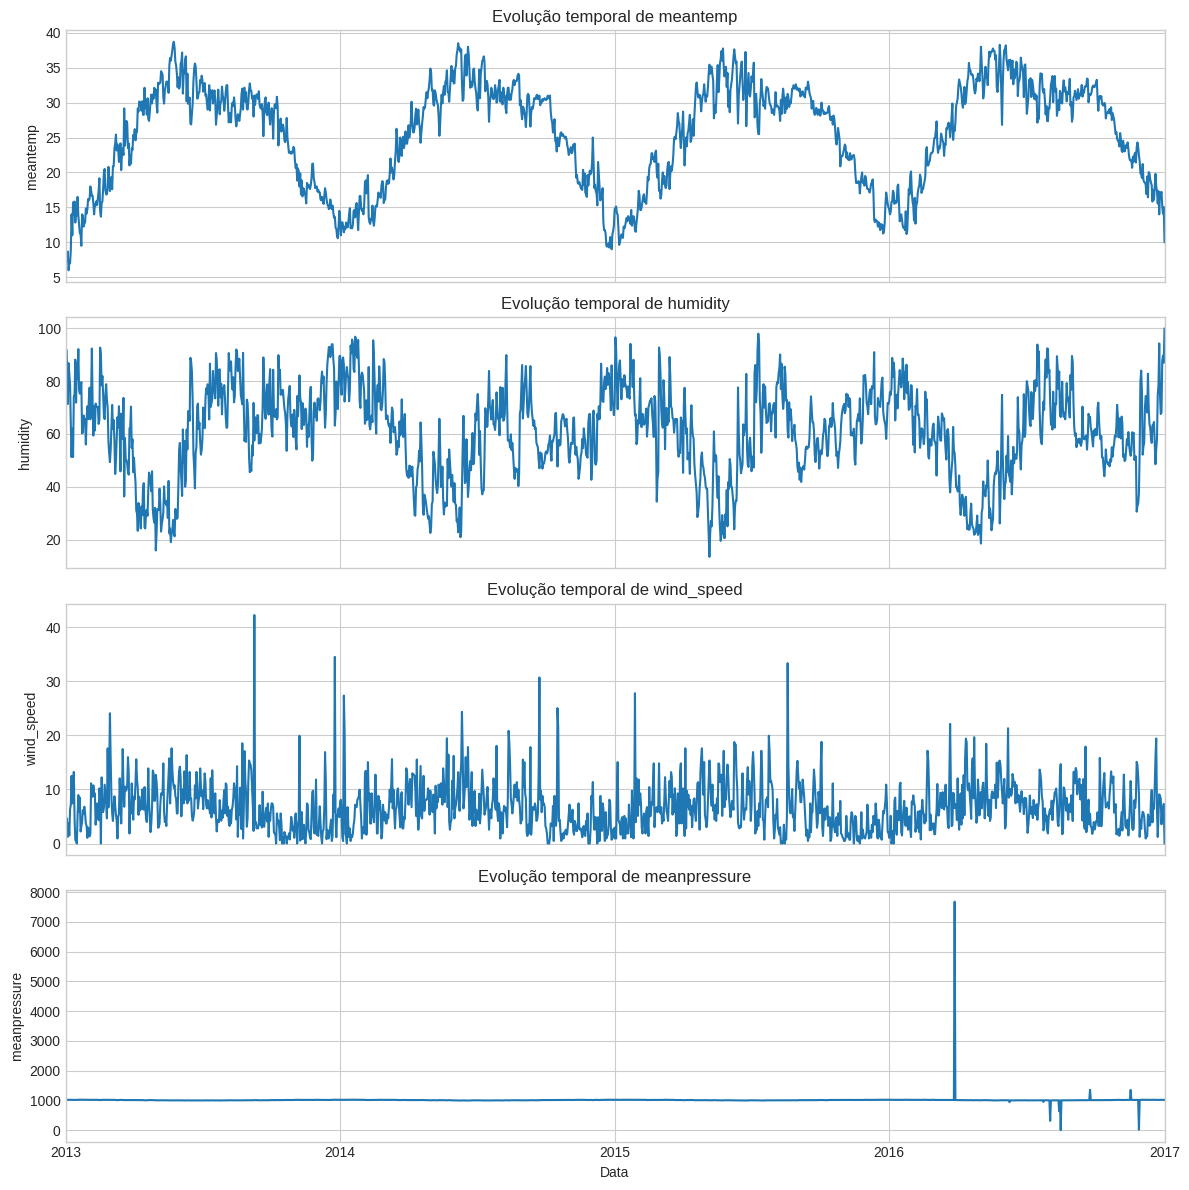

In [ ]:
# 3.6 Visualização das séries numéricas ao longo do tempo

df_plot = df.set_index(date_col)

fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(12, 3 * len(numeric_cols)), sharex=True)
if len(numeric_cols) == 1:
    axes = [axes]

for ax, col in zip(axes, numeric_cols):
    df_plot[col].plot(ax=ax)
    ax.set_title(f"Evolução temporal de {col}")
    ax.set_xlabel("Data")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()


### 3.6 Revisão dos outliers em `meanpressure`

A análise inicial por IQR identificou nove possíveis outliers em `meanpressure`. No entanto, ao inspecionar os valores individualmente, adotamos um critério mais conservador:

- consideramos como **erros de registro claros** apenas valores fisicamente impossíveis, como:
  - `7679.33` hPa (2016-03-28)
  - `-3.04` hPa (2016-08-16)
  - `12.05` hPa (2016-11-28)
  - `310.44` hPa (2016-08-02)

- mantivemos os demais valores extremos (como 938, 946, 633 e 1350 hPa) como parte dos dados, interpretando-os como dias potencialmente atípicos, mas não necessariamente inválidos.

Esses três pontos foram tratados como dados ausentes e reconstruídos por interpolação temporal. Essa escolha busca um equilíbrio entre:
- corrigir erros grosseiros que distorceriam o escalonamento das features; e
- evitar uma “limpeza” excessiva que remova variações legítimas da série.


In [ ]:
import numpy as np

# Garantir ordenação e índice por data
df = df.sort_values(by=date_col).reset_index(drop=True)
df = df.set_index(date_col)

# Lista de datas com valores de pressão considerados erros claros
hard_error_dates = [
    "2016-03-28",  # 7679.33
    "2016-08-16",  # -3.04
    "2016-11-28",  # 12.05
    "2016-08-02",  # 310.44
]

hard_error_dates = pd.to_datetime(hard_error_dates)

mask_hard = df.index.isin(hard_error_dates)

print("Número de registros marcados como erro claro em meanpressure:", mask_hard.sum())
display(df.loc[mask_hard, ["meantemp", "humidity", "wind_speed", "meanpressure"]])

# 1) Marcar apenas esses valores como NaN
df.loc[mask_hard, "meanpressure"] = np.nan

# 2) Interpolar no tempo
df["meanpressure"] = df["meanpressure"].interpolate(method="time")

# 3) Garantir que não restaram NaNs nas pontas
df["meanpressure"] = df["meanpressure"].ffill().bfill()

print("\nEstatísticas de meanpressure após correção pontual:")
display(df["meanpressure"].describe())


Número de registros marcados como erro claro em meanpressure: 4


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-03-28,25.933333,52.800000,6.546667,7679.333333
2016-08-02,30.687500,72.125000,6.375000,310.437500
2016-08-16,31.333333,66.416667,14.666667,-3.041667
2016-11-28,22.454545,37.318182,9.185714,12.045455



Estatísticas de meanpressure após correção pontual:


count    1462.000000
mean     1008.386215
std        17.840298
min       633.900000
25%      1001.611607
50%      1008.571429
75%      1014.921875
max      1352.615385
Name: meanpressure, dtype: float64

### 3.7 Preparação final dos dados para o modelo LSTM multivariado

Após a EDA e o tratamento pontual de outliers evidentes em `meanpressure`, vamos preparar os dados para o modelo LSTM:

- **Features de entrada**: `meantemp`, `humidity`, `wind_speed`, `meanpressure`.
- **Variável alvo**: `meantemp` (previsão de um passo à frente).
- **Escalonamento**:
  - aplicaremos um `MinMaxScaler` para as features (todas juntas);
  - aplicaremos um segundo `MinMaxScaler` apenas para a variável alvo, para facilitar a interpretação posterior dos erros na escala original.
- **Janelamento (lookback)**:
  - usaremos janelas de `lookback` dias (por exemplo, 30) para prever a temperatura do dia seguinte;
  - isso gera tensores de entrada no formato `(amostras, lookback, n_features)`.

Depois de criar as sequências, faremos a divisão temporal em:

- treino: 70 % das sequências iniciais;
- validação: 15 % posteriores;
- teste: 15 % finais.

Essa divisão respeita a ordem temporal e será usada em todas as iterações de modelos LSTM a partir de agora.


In [ ]:
from sklearn.preprocessing import MinMaxScaler


feature_cols = ["meantemp", "humidity", "wind_speed", "meanpressure"]
target_col = "meantemp"

# Matriz de features (X) e vetor alvo (y)
X_raw = df[feature_cols].values.astype("float32")
y_raw = df[[target_col]].values.astype("float32")

# Escalonamento das features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X_raw)

# Escalonamento do alvo (apenas meantemp)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y_raw)

print("Shape X_scaled:", X_scaled.shape)
print("Shape y_scaled:", y_scaled.shape)


Shape X_scaled: (1462, 4)
Shape y_scaled: (1462, 1)


In [ ]:
import numpy as np

def create_multivariate_sequences(X, y, lookback):
    """
    Cria sequências para LSTM a partir de séries multivariadas.

    X: array 2D de shape (n_amostras, n_features)
    y: array 2D de shape (n_amostras, 1)
    lookback: número de passos de tempo usados como entrada

    Retorna:
    X_seq: array 3D de shape (n_seq, lookback, n_features)
    y_seq: array 2D de shape (n_seq, 1)
    """
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i + lookback, :])
        ys.append(y[i + lookback, :])
    return np.array(Xs), np.array(ys)

lookback = 30  # você pode ajustar depois e comparar nas iterações

X_all, y_all = create_multivariate_sequences(X_scaled, y_scaled, lookback)

print("Shape X_all:", X_all.shape)  # (n_seq, lookback, n_features)
print("Shape y_all:", y_all.shape)  # (n_seq, 1)


Shape X_all: (1432, 30, 4)
Shape y_all: (1432, 1)


In [ ]:
n_samples = X_all.shape[0]

train_size = int(n_samples * 0.7)
val_size = int(n_samples * 0.15)
test_size = n_samples - train_size - val_size

print(f"Número total de sequências: {n_samples}")
print(f"Tamanho treino: {train_size}")
print(f"Tamanho validação: {val_size}")
print(f"Tamanho teste: {test_size}")

X_train = X_all[:train_size]
y_train = y_all[:train_size]

X_val = X_all[train_size:train_size + val_size]
y_val = y_all[train_size:train_size + val_size]

X_test = X_all[train_size + val_size:]
y_test = y_all[train_size + val_size:]

print("Shapes finais:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Número total de sequências: 1432
Tamanho treino: 1002
Tamanho validação: 214
Tamanho teste: 216
Shapes finais:
X_train: (1002, 30, 4) y_train: (1002, 1)
X_val: (214, 30, 4) y_val: (214, 1)
X_test: (216, 30, 4) y_test: (216, 1)


## 4. Modelagem com LSTM

### 4.1 Primeira iteração: LSTM “shallow” (baseline)

Nesta primeira etapa vamos treinar um modelo LSTM simples, que servirá como **baseline** para as demais versões:

- **Entradas**: janelas de `lookback` dias contendo as quatro features (`meantemp`, `humidity`, `wind_speed`, `meanpressure`), já normalizadas.
- **Saída**: previsão normalizada da temperatura média (`meantemp`) para o dia seguinte.
- **Arquitetura**:
  - 1 camada LSTM com 32 unidades;
  - 1 camada densa final com 1 neurônio (regressão).
- **Função de perda**: MSE (erro quadrático médio).
- **Otimizador**: Adam.
- **Métricas**: MAE (erro absoluto médio).


In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Lista global onde vamos guardar os resultados de cada modelo
if "model_results" not in globals():
    model_results = []

def evaluate_and_log_model(model, history, model_name, params):
    """
    Avalia o modelo em treino/val/test na escala ORIGINAL da temperatura
    e registra os resultados na lista global `model_results`.

    Parâmetros
    ----------
    model : keras.Model
        Modelo treinado.
    history : keras.callbacks.History
        Objeto retornado pelo .fit(), com histórico de loss/metrics.
    model_name : str
        Nome curto para identificar o modelo (ex: 'LSTM_baseline').
    params : dict
        Dicionário com hiperparâmetros relevantes (lookback, unidades, etc.).
    """

    def _eval_split(X, y_scaled):
        # Predição na escala normalizada
        y_pred_scaled = model.predict(X, verbose=0)

        # Volta para a escala original
        y_true = scaler_y.inverse_transform(y_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)

        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        return mae, rmse

    # Avalia cada split
    mae_train, rmse_train = _eval_split(X_train, y_train)
    mae_val, rmse_val     = _eval_split(X_val,   y_val)
    mae_test, rmse_test   = _eval_split(X_test,  y_test)

    # Melhor val_loss durante o treinamento
    best_val_loss = float(np.min(history.history["val_loss"]))

    # Quantas épocas de fato foram treinadas (early stopping pode parar antes)
    epochs_trained = len(history.history["loss"])

    # Monta o registro deste modelo
    result = {
        "model": model_name,
        "lookback": params.get("lookback"),
        "units_lstm": params.get("units_lstm"),
        "batch_size": params.get("batch_size"),
        "epochs_trained": epochs_trained,
        "best_val_loss": best_val_loss,
        "train_mae": mae_train,
        "train_rmse": rmse_train,
        "val_mae": mae_val,
        "val_rmse": rmse_val,
        "test_mae": mae_test,
        "test_rmse": rmse_test,
    }

    model_results.append(result)

    # Exibe a tabela atualizada a cada chamada
    results_df = pd.DataFrame(model_results)
    display(results_df)

    return results_df


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)

n_features = X_train.shape[2]

# Definição do modelo baseline (shallow)
baseline_model = Sequential([
    LSTM(32, input_shape=(lookback, n_features)),
    Dense(1)
])

baseline_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

# Early stopping: monitora val_loss, patience=10, restaura os melhores pesos
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

epochs = 100   # podemos deixar alto, o early stopping interrompe antes se necessário
batch_size = 32

history_baseline = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0817 - mae: 0.2323 - rmse: 0.2795 - val_loss: 0.0166 - val_mae: 0.1069 - val_rmse: 0.1288
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0088 - mae: 0.0746 - rmse: 0.0934 - val_loss: 0.0052 - val_mae: 0.0568 - val_rmse: 0.0721
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mae: 0.0546 - rmse: 0.0692 - val_loss: 0.0047 - val_mae: 0.0541 - val_rmse: 0.0683
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mae: 0.0522 - rmse: 0.0663 - val_loss: 0.0045 - val_mae: 0.0528 - val_rmse: 0.0670
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0042 - mae: 0.0514 - rmse: 0.0650 - val_loss: 0.0043 - val_mae: 0.0515 - val_rmse: 0.0655
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mae: 0.0505 - rmse: 0.0638 - val_loss: 0.0041 - val_mae: 0.0501 - val_rmse: 0.0640
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mae: 0.0496 - rmse: 0.062

In [ ]:
baseline_params = {
    "lookback": lookback,
    "units_lstm": 32,
    "batch_size": batch_size,
}

results_df = evaluate_and_log_model(
    baseline_model,
    history_baseline,
    model_name="LSTM_baseline",
    params=baseline_params
)


,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.17362,1.515928,1.310341,1.630812


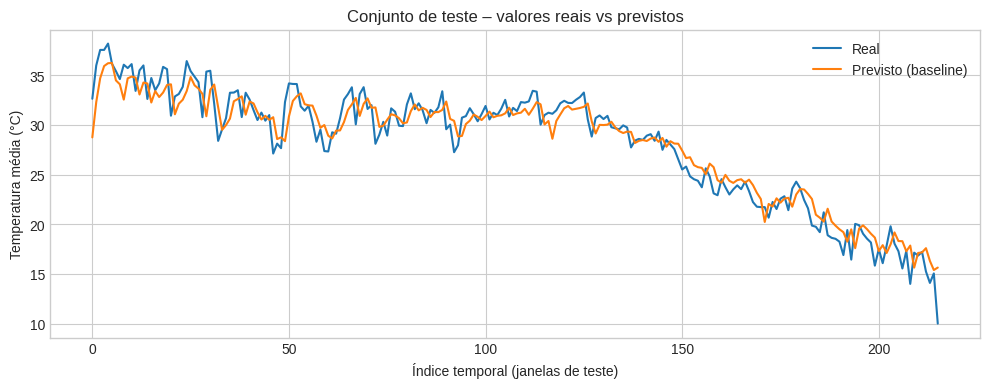

In [ ]:
# Comparação entre valores reais e previstos (conjunto de teste) – sem gráfico de erro separado

y_test_pred_scaled = baseline_model.predict(X_test, verbose=0)

# Volta para escala original
y_test_true = scaler_y.inverse_transform(y_test)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

y_test_true_1d = y_test_true.ravel()
y_test_pred_1d = y_test_pred.ravel()

plt.figure(figsize=(12, 4))
plt.plot(y_test_true_1d, label="Real")
plt.plot(y_test_pred_1d, label="Previsto (baseline)")
plt.title("Conjunto de teste – valores reais vs previstos")
plt.xlabel("Índice temporal (janelas de teste)")
plt.ylabel("Temperatura média (°C)")
plt.legend()
plt.grid(True)
plt.show()


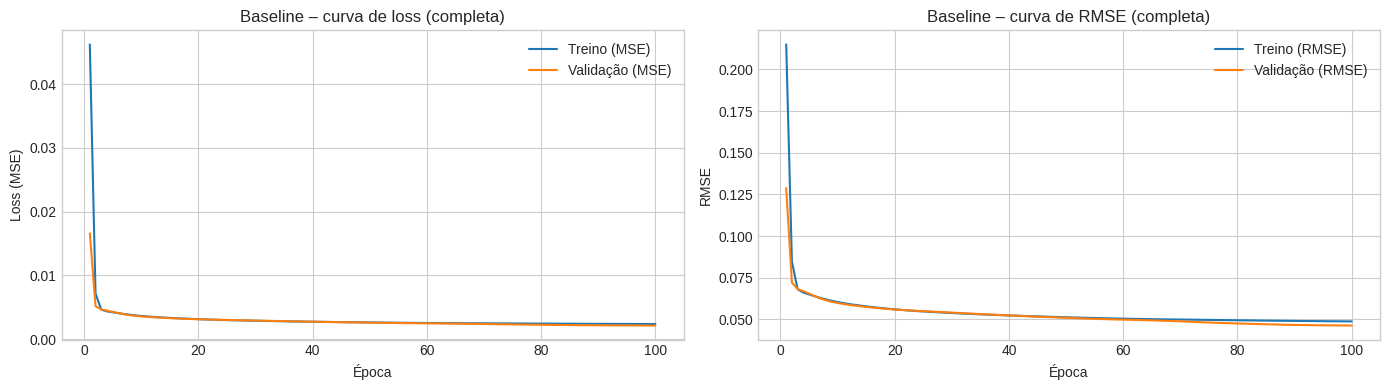

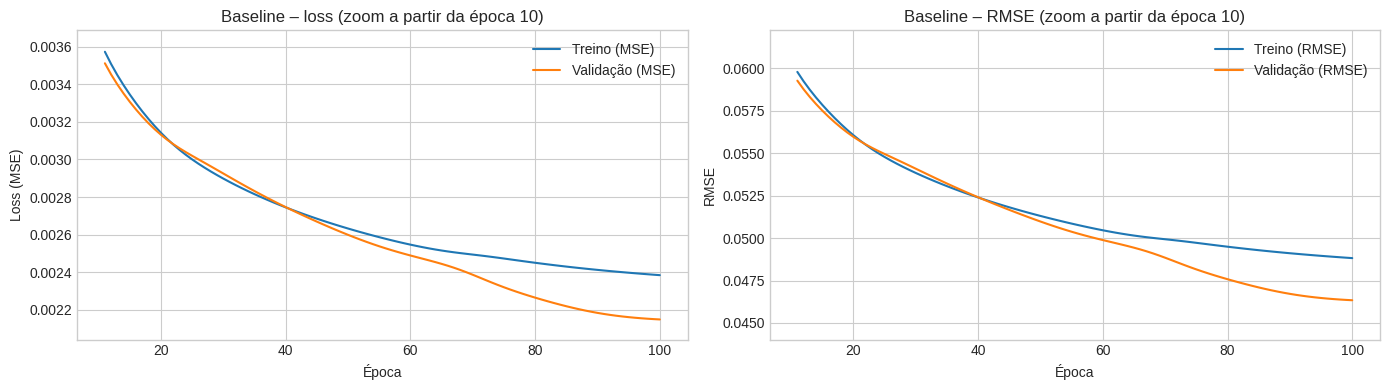

In [ ]:
history = history_baseline  # só para clareza

epochs = np.arange(1, len(history.history["loss"]) + 1)

# -------------------- Figura 1: curvas completas --------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss (MSE) completo
axes[0].plot(epochs, history.history["loss"], label="Treino (MSE)")
axes[0].plot(epochs, history.history["val_loss"], label="Validação (MSE)")
axes[0].set_title("Baseline – curva de loss (completa)")
axes[0].set_xlabel("Época")
axes[0].set_ylabel("Loss (MSE)")
axes[0].legend()
axes[0].grid(True)

# RMSE completo
axes[1].plot(epochs, history.history["rmse"], label="Treino (RMSE)")
axes[1].plot(epochs, history.history["val_rmse"], label="Validação (RMSE)")
axes[1].set_title("Baseline – curva de RMSE (completa)")
axes[1].set_xlabel("Época")
axes[1].set_ylabel("RMSE")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# -------------------- Figura 2: zoom nas últimas épocas --------------------
zoom_start = 10  # por exemplo, ignorar as 10 primeiras épocas mais turbulentas

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Zoom loss
axes[0].plot(epochs[zoom_start:], history.history["loss"][zoom_start:], label="Treino (MSE)")
axes[0].plot(epochs[zoom_start:], history.history["val_loss"][zoom_start:], label="Validação (MSE)")
axes[0].set_title(f"Baseline – loss (zoom a partir da época {zoom_start})")
axes[0].set_xlabel("Época")
axes[0].set_ylabel("Loss (MSE)")
axes[0].legend()
axes[0].grid(True)

# Ajuste automático de limites de y com pequena margem
loss_slice = history.history["val_loss"][zoom_start:]
axes[0].set_ylim(min(loss_slice)*0.95, max(loss_slice)*1.05)

# Zoom RMSE
axes[1].plot(epochs[zoom_start:], history.history["rmse"][zoom_start:], label="Treino (RMSE)")
axes[1].plot(epochs[zoom_start:], history.history["val_rmse"][zoom_start:], label="Validação (RMSE)")
axes[1].set_title(f"Baseline – RMSE (zoom a partir da época {zoom_start})")
axes[1].set_xlabel("Época")
axes[1].set_ylabel("RMSE")
axes[1].legend()
axes[1].grid(True)

rmse_slice = history.history["val_rmse"][zoom_start:]
axes[1].set_ylim(min(rmse_slice)*0.95, max(rmse_slice)*1.05)

plt.tight_layout()
plt.show()


### 4.2 Análise da baseline e motivação para o Modelo 2

A LSTM baseline apresentou desempenho razoável:

- **RMSE (escala original)**  
  - Treino ≈ 1.57  
  - Validação ≈ 1.52  
  - Teste ≈ 1.63  

- **Curvas de loss / RMSE**  
  - As curvas de treino e validação caem rapidamente nas primeiras épocas e depois se estabilizam muito próximas.  
  - Não há aumento consistente de `val_loss` enquanto `loss` continua caindo, o que seria um sinal clássico de **overfitting** forte.  
  - Visualmente, as curvas sugerem um modelo relativamente bem regularizado, com comportamento semelhante em treino e validação.

- **Comparação real vs previsto (teste)**  
  - O modelo acompanha bem a tendência geral e a sazonalidade da série.  
  - Os maiores erros aparecem em picos e vales mais abruptos, com o modelo tendendo a suavizar as variações (erro típico em torno de alguns °C).

Em resumo, a baseline **não indica níveis fortes de overfitting**. Pelo contrário, os resultados sugerem que o modelo pode estar mais limitado por **capacidade** (modelo simples que suaviza demais) do que por excesso de complexidade.

Diante disso, a próxima etapa será tentar **melhorar as métricas** (RMSE/MAE) aumentando a capacidade da rede. No **Modelo 2**, manteremos a mesma arquitetura básica (uma camada LSTM seguida de uma camada densa), porém:

- aumentaremos o número de unidades da LSTM (por exemplo, de 32 para 64);  
- manteremos o mesmo `lookback`, `batch_size` e esquema de *early stopping*.

O objetivo é avaliar se **apenas aumentar o número de neurônios** reduz o erro em validação e teste sem introduzir sinais significativos de overfitting.


In [ ]:
# Modelo 2: LSTM com mais neurônios (aumentar capacidade) + log de resultados

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

tf.random.set_seed(42)

n_features = X_train.shape[2]

# Definição do Modelo 2 – mesma arquitetura, mais unidades na LSTM
model2 = Sequential([
    LSTM(64, input_shape=(lookback, n_features)),  # antes: 32 unidades
    Dense(1)
])

model2.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

# Early stopping (igual ao usado na baseline)
early_stopping_2 = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

epochs = 100     # mantemos o mesmo limite máximo
batch_size = 32  # mantemos o mesmo batch

history_model2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping_2],
    verbose=1
)

# Registrar o Modelo 2 na lista de resultados
model2_params = {
    "lookback": lookback,
    "units_lstm": 64,
    "batch_size": batch_size,
}

results_df = evaluate_and_log_model(
    model2,
    history_model2,
    model_name="LSTM_64_units",
    params=model2_params
)


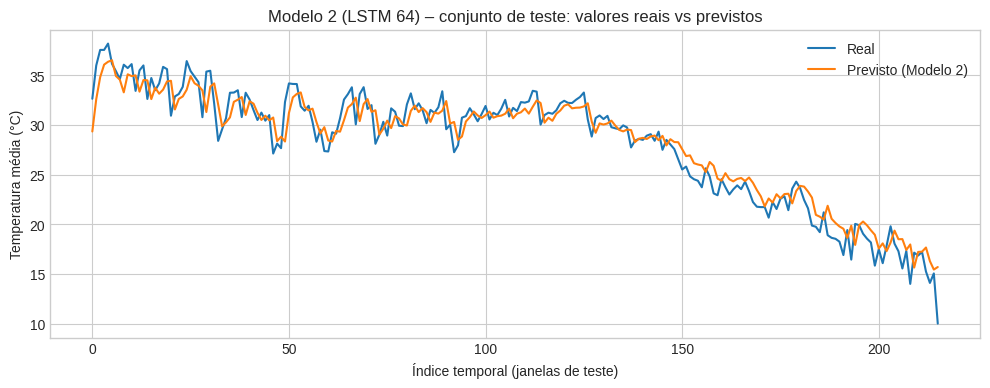

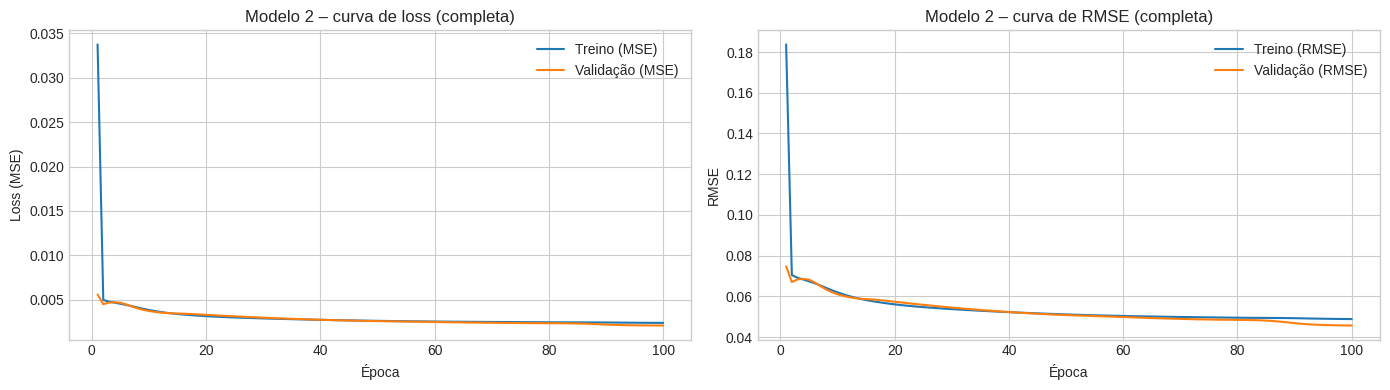

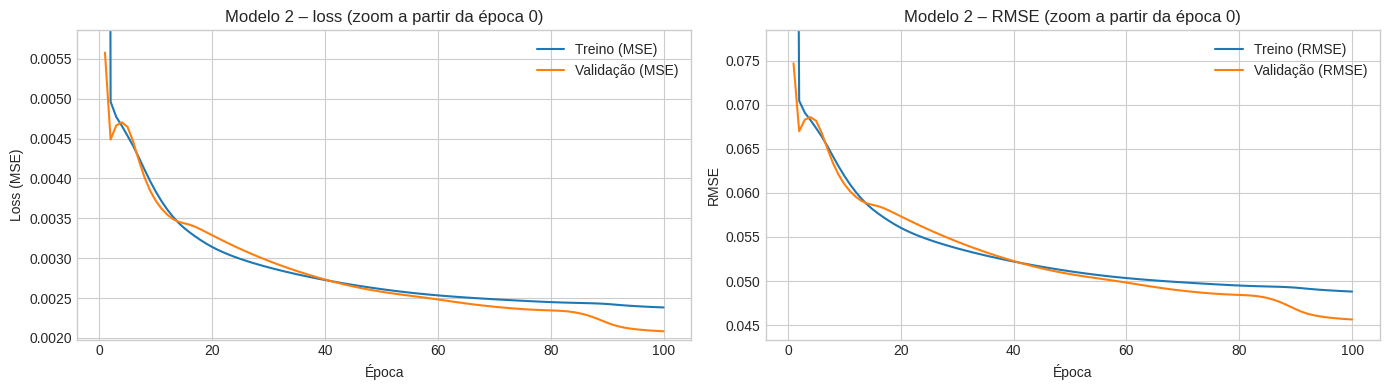

In [ ]:
# Avaliação gráfica do Modelo 2 (LSTM_64_units):
# 1) valores reais vs previstos (teste)
# 2) curvas de loss e RMSE (treino vs validação, com zoom)

# =========================
# Parte 1 – Reais vs previstos (conjunto de teste)
# =========================

y_test_pred_scaled_m2 = model2.predict(X_test, verbose=0)

# Volta para escala original
y_test_true_m2 = scaler_y.inverse_transform(y_test)
y_test_pred_m2 = scaler_y.inverse_transform(y_test_pred_scaled_m2)

y_test_true_m2_1d = y_test_true_m2.ravel()
y_test_pred_m2_1d = y_test_pred_m2.ravel()

plt.figure(figsize=(12, 4))
plt.plot(y_test_true_m2_1d, label="Real")
plt.plot(y_test_pred_m2_1d, label="Previsto (Modelo 2)")
plt.title("Modelo 2 (LSTM 64) – conjunto de teste: valores reais vs previstos")
plt.xlabel("Índice temporal (janelas de teste)")
plt.ylabel("Temperatura média (°C)")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# Parte 2 – Curvas de loss e RMSE (completo + zoom)
# =========================

history = history_model2
epochs = np.arange(1, len(history.history["loss"]) + 1)

# Figura 1 – curvas completas
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Loss (MSE) completo
axes[0].plot(epochs, history.history["loss"], label="Treino (MSE)")
axes[0].plot(epochs, history.history["val_loss"], label="Validação (MSE)")
axes[0].set_title("Modelo 2 – curva de loss (completa)")
axes[0].set_xlabel("Época")
axes[0].set_ylabel("Loss (MSE)")
axes[0].legend()
axes[0].grid(True)

# RMSE completo
axes[1].plot(epochs, history.history["rmse"], label="Treino (RMSE)")
axes[1].plot(epochs, history.history["val_rmse"], label="Validação (RMSE)")
axes[1].set_title("Modelo 2 – curva de RMSE (completa)")
axes[1].set_xlabel("Época")
axes[1].set_ylabel("RMSE")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Figura 2 – zoom nas últimas épocas
zoom_start = 0  # ajuste se quiser ver menos/mais épocas iniciais

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Zoom loss
axes[0].plot(epochs[zoom_start:], history.history["loss"][zoom_start:], label="Treino (MSE)")
axes[0].plot(epochs[zoom_start:], history.history["val_loss"][zoom_start:], label="Validação (MSE)")
axes[0].set_title(f"Modelo 2 – loss (zoom a partir da época {zoom_start})")
axes[0].set_xlabel("Época")
axes[0].set_ylabel("Loss (MSE)")
axes[0].legend()
axes[0].grid(True)

loss_slice_m2 = history.history["val_loss"][zoom_start:]
axes[0].set_ylim(min(loss_slice_m2)*0.95, max(loss_slice_m2)*1.05)

# Zoom RMSE
axes[1].plot(epochs[zoom_start:], history.history["rmse"][zoom_start:], label="Treino (RMSE)")
axes[1].plot(epochs[zoom_start:], history.history["val_rmse"][zoom_start:], label="Validação (RMSE)")
axes[1].set_title(f"Modelo 2 – RMSE (zoom a partir da época {zoom_start})")
axes[1].set_xlabel("Época")
axes[1].set_ylabel("RMSE")
axes[1].legend()
axes[1].grid(True)

rmse_slice_m2 = history.history["val_rmse"][zoom_start:]
axes[1].set_ylim(min(rmse_slice_m2)*0.95, max(rmse_slice_m2)*1.05)

plt.tight_layout()
plt.show()


### 4.3 Modelo 3 – LSTM empilhada (duas camadas)

Os dois primeiros modelos (LSTM com 32 e 64 unidades) mostraram:

- desempenho semelhante em treino, validação e teste;
- curvas de loss e RMSE praticamente sobrepostas, sem sinais fortes de overfitting;
- melhoria modesta ao aumentar o número de unidades na mesma arquitetura.

Isso sugere que o modelo já está generalizando razoavelmente bem, mas pode estar limitado em termos de **capacidade de representar padrões temporais mais complexos** apenas com uma única camada LSTM.

Como próximo passo, em vez de apenas aumentar ainda mais o número de neurônios em uma única camada, vamos testar uma **arquitetura mais profunda**, empilhando duas camadas LSTM:

- **Arquitetura proposta (Modelo 3)**  
  - 1ª camada: `LSTM(64, return_sequences=True)`  
    - captura padrões de curto prazo e produz uma sequência de estados ocultos.  
  - 2ª camada: `LSTM(32)`  
    - resume as informações da sequência anterior em um estado final mais rico.  
  - Camada de saída: `Dense(1)` (previsão escalar da temperatura média do dia seguinte).

- **Hiperparâmetros mantidos**  
  - `lookback = 30`  
  - `batch_size = 32`  
  - otimizador `adam`, perda `MSE`, métricas `MAE` e `RMSE`  
  - *early stopping* monitorando `val_loss` com `patience = 10` e restauração dos melhores pesos.

O objetivo é avaliar se essa profundidade extra na LSTM:

- reduz o RMSE em validação e teste, capturando melhor a dinâmica da série;  
- ou começa a introduzir sinais de overfitting (curvas de validação se afastando das de treino).

Os resultados serão comparados diretamente com os Modelos 1 e 2 na tabela de experimentos.


In [ ]:
# Modelo 3: LSTM empilhada (duas camadas) + log de resultados

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

tf.random.set_seed(42)

n_features = X_train.shape[2]

model3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(lookback, n_features)),
    LSTM(32),
    Dense(1)
])

model3.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

early_stopping_3 = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

epochs = 100   # mantemos o mesmo limite
batch_size = 32

history_model3 = model3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping_3],
    verbose=1
)

# Registrar o Modelo 3 na lista de resultados
model3_params = {
    "lookback": lookback,
    "units_lstm": "64-32",  # duas camadas: 64 e 32 unidades
    "batch_size": batch_size,
}

results_df = evaluate_and_log_model(
    model3,
    history_model3,
    model_name="LSTM_stacked_64_32",
    params=model3_params
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1170 - mae: 0.2643 - rmse: 0.3268 - val_loss: 0.0071 - val_mae: 0.0678 - val_rmse: 0.0840
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0068 - mae: 0.0656 - rmse: 0.0822 - val_loss: 0.0054 - val_mae: 0.0596 - val_rmse: 0.0738
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0057 - mae: 0.0599 - rmse: 0.0754 - val_loss: 0.0054 - val_mae: 0.0590 - val_rmse: 0.0734
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0596 - rmse: 0.0748 - val_loss: 0.0054 - val_mae: 0.0590 - val_rmse: 0.0735
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0582 - rmse: 0.0730 - val_loss: 0.0050 - val_mae: 0.0567 - val_rmse: 0.0710
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0558 - rmse: 0.0704 - val_loss: 0.0048 - val_mae: 0.0548 - val_rmse: 0.0691
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mae: 0.0540 - rmse: 0.0684 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637


### 4.4 Resultado da LSTM empilhada (64–32) e decisão de descartá-la

Testamos uma arquitetura mais profunda com duas camadas LSTM:

- 1ª camada: `LSTM(64, return_sequences=True)`  
- 2ª camada: `LSTM(32)`  
- Saída: `Dense(1)`

Os resultados ficaram bem abaixo dos modelos anteriores:

- **Baseline (32 unidades, 1 camada)**  
  - `val_rmse ≈ 1.52` · `test_rmse ≈ 1.63`
- **Modelo 2 (64 unidades, 1 camada)**  
  - `val_rmse ≈ 1.49` · `test_rmse ≈ 1.61`
- **LSTM empilhada 64–32 (2 camadas)**  
  - `val_rmse ≈ 2.25` · `test_rmse ≈ 2.18`  
  - early stopping interrompeu o treino na **época 17**, com `train_rmse` também mais alto que nos modelos anteriores.

Ou seja, ao empilhar as camadas:

- o modelo ficou mais difícil de otimizar (mesmo com early stopping, o erro de treino permaneceu alto);  
- não houve ganho de capacidade efetiva, pelo contrário, **as métricas de validação e teste pioraram de forma consistente**.

Diante disso, concluímos que, para este conjunto de dados e configuração atual, **a arquitetura mais profunda não trouxe benefícios**.  
Vamos, portanto, retornar à configuração com **apenas uma camada LSTM** e, como próximo passo, testar um aumento de capacidade nessa única camada (por exemplo, **128 unidades**), mantendo os demais hiperparâmetros constantes.


In [ ]:
# Modelo 4: LSTM com 128 neurônios (uma camada) + log de resultados

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

tf.random.set_seed(42)

n_features = X_train.shape[2]

model4 = Sequential([
    LSTM(128, input_shape=(lookback, n_features)),
    Dense(1)
])

model4.compile(
    optimizer="adam",
    loss="mse",
    metrics=[
        "mae",
        tf.keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

early_stopping_4 = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

epochs = 100
batch_size = 32

history_model4 = model4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping_4],
    verbose=1
)

# Registrar o Modelo 4 na lista de resultados
model4_params = {
    "lookback": lookback,
    "units_lstm": 128,
    "batch_size": batch_size,
}

results_df = evaluate_and_log_model(
    model4,
    history_model4,
    model_name="LSTM_128_units",
    params=model4_params
)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0650 - mae: 0.1909 - rmse: 0.2448 - val_loss: 0.0048 - val_mae: 0.0538 - val_rmse: 0.0696
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mae: 0.0560 - rmse: 0.0715 - val_loss: 0.0046 - val_mae: 0.0530 - val_rmse: 0.0680
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0047 - mae: 0.0540 - rmse: 0.0682 - val_loss: 0.0047 - val_mae: 0.0535 - val_rmse: 0.0683
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0044 - mae: 0.0526 - rmse: 0.0664 - val_loss: 0.0047 - val_mae: 0.0543 - val_rmse: 0.0687
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0043 - mae: 0.0517 - rmse: 0.0654 - val_loss: 0.0047 - val_mae: 0.0540 - val_rmse: 0.0682
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mae: 0.0507 - rmse: 0.0643 - val_loss: 0.0045 - val_mae: 0.0529 - val_rmse: 0.0668
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mae: 0.0497 - rmse: 0.0631 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316


### 4.5 Ajustes na estratégia de experimentação

Os resultados do Modelo 4 (LSTM com 128 neurônios) ficaram **inferiores** aos do Modelo 2 (64 neurônios) e próximos ou piores que a baseline. Em resumo, aumentar ainda mais a capacidade da única camada LSTM:

- não trouxe ganho relevante em `val_rmse` e `test_rmse`;
- aumentou o custo de treinamento;
- reforçou a percepção de que, a partir de certo ponto, o aumento de neurônios passa a ter retorno marginal ou até negativo.

Para evitar que o notebook fique excessivamente poluído e repetitivo, a partir deste ponto adotaremos as seguintes decisões:

1. **Agrupar o código de novos modelos em uma única célula por experimento**  
   - Cada nova variação de arquitetura/hiperparâmetros será construída, treinada e registrada (via `evaluate_and_log_model`) dentro de uma única célula de código.
   - Isso mantém o histórico de resultados completo na tabela `model_results`, sem espalhar muitas células quase idênticas ao longo do notebook.

2. **Plotar gráficos apenas para modelos com desempenho competitivo**  
   - Gráficos detalhados (curvas de loss/RMSE e série real vs prevista) serão gerados apenas para modelos que:
     - apresentem métricas melhores ou, no mínimo, muito próximas dos melhores modelos atuais; ou
     - sejam arquiteturas conceitualmente importantes para discussão (por exemplo, baseline).
   - Modelos claramente piores (como a LSTM empilhada e a LSTM com 128 neurônios) serão apenas registrados na tabela, sem geração adicional de gráficos.

Essa estratégia ajuda a manter o notebook mais compacto e focado, sem perder o rigor experimental nem a rastreabilidade dos resultados.


In [ ]:
# Teste de diferentes lookbacks com a mesma arquitetura LSTM(64)
# Lookbacks a serem testados: 14 e 60 dias
# A célula:
#  - refaz o janelamento para cada lookback
#  - treina um modelo LSTM(64) com early stopping
#  - registra os resultados na tabela model_results

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)

lookbacks_to_test = [14, 60]
epochs = 100
batch_size = 32
n_features = X_scaled.shape[1]

# dicionários opcionais para armazenar modelos e históricos, caso queiramos
# plotar depois apenas os melhores
if "trained_models" not in globals():
    trained_models = {}
if "model_histories" not in globals():
    model_histories = {}

for lb in lookbacks_to_test:
    print(f"\n=== Treinando LSTM(64) com lookback = {lb} dias ===")

    # 1) Criar sequências para este lookback
    X_all_lb, y_all_lb = create_multivariate_sequences(X_scaled, y_scaled, lb)

    n_samples_lb = X_all_lb.shape[0]
    train_size = int(n_samples_lb * 0.7)
    val_size = int(n_samples_lb * 0.15)
    test_size = n_samples_lb - train_size - val_size

    # 2) Atualizar splits globais (avaliador usa essas variáveis)
    X_train = X_all_lb[:train_size]
    y_train = y_all_lb[:train_size]

    X_val = X_all_lb[train_size:train_size + val_size]
    y_val = y_all_lb[train_size:train_size + val_size]

    X_test = X_all_lb[train_size + val_size:]
    y_test = y_all_lb[train_size + val_size:]

    print(f"Shape X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

    # 3) Definir o modelo LSTM com 64 unidades
    model_lb = Sequential([
        LSTM(64, input_shape=(lb, n_features)),
        Dense(1)
    ])

    model_lb.compile(
        optimizer="adam",
        loss="mse",
        metrics=[
            "mae",
            tf.keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )

    early_stopping_lb = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    # 4) Treinar
    history_lb = model_lb.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping_lb],
        verbose=1
    )

    # 5) Guardar modelo e histórico, caso queiramos plotar depois
    model_name = f"LSTM_64_units_lookback{lb}"
    trained_models[model_name] = model_lb
    model_histories[model_name] = history_lb

    # 6) Registrar resultados na tabela global model_results
    params_lb = {
        "lookback": lb,
        "units_lstm": 64,
        "batch_size": batch_size,
    }

    results_df = evaluate_and_log_model(
        model_lb,
        history_lb,
        model_name=model_name,
        params=params_lb
    )

print("\nTabela final de resultados atualizada:")
display(results_df)



=== Treinando LSTM(64) com lookback = 14 dias ===
Shape X_train: (1013, 14, 4), X_val: (217, 14, 4), X_test: (218, 14, 4)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.2136 - mae: 0.3704 - rmse: 0.4455 - val_loss: 0.0159 - val_mae: 0.1016 - val_rmse: 0.1261
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0100 - mae: 0.0806 - rmse: 0.0995 - val_loss: 0.0042 - val_mae: 0.0509 - val_rmse: 0.0647
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0053 - mae: 0.0574 - rmse: 0.0725 - val_loss: 0.0042 - val_mae: 0.0511 - val_rmse: 0.0649
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0048 - mae: 0.0546 - rmse: 0.0691 - val_loss: 0.0042 - val_mae: 0.0514 - val_rmse: 0.0652
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - mae: 0.0530 - rmse: 0.0670 - val_loss: 0.0044 - val_mae: 0.0525 - val_rmse: 0.0663
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0044 - mae: 0.0520 - rmse: 0.0660 - val_loss: 0.0044 - val_mae: 0.0529 - val_rmse: 0.0666
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - mae: 0.0513 - rmse: 0.0652 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519



=== Treinando LSTM(64) com lookback = 60 dias ===
Shape X_train: (981, 60, 4), X_val: (210, 60, 4), X_test: (211, 60, 4)
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1337 - mae: 0.2848 - rmse: 0.3497 - val_loss: 0.0100 - val_mae: 0.0824 - val_rmse: 0.1002
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - mae: 0.0698 - rmse: 0.0895 - val_loss: 0.0046 - val_mae: 0.0522 - val_rmse: 0.0678
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0053 - mae: 0.0569 - rmse: 0.0729 - val_loss: 0.0045 - val_mae: 0.0517 - val_rmse: 0.0667
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mae: 0.0559 - rmse: 0.0710 - val_loss: 0.0044 - val_mae: 0.0512 - val_rmse: 0.0660
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0048 - mae: 0.0548 - rmse: 0.0695 - val_loss: 0.0043 - val_mae: 0.0508 - val_rmse: 0.0655
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mae: 0.0543 - rmse: 0.0686 - val_loss: 0.0042 - val_mae: 0.0503 - val_rmse: 0.0650
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - mae: 0.0536 - rmse: 0.0676 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588



Tabela final de resultados atualizada:


,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588



=== Gráficos para LSTM_64_units_lookback14 ===


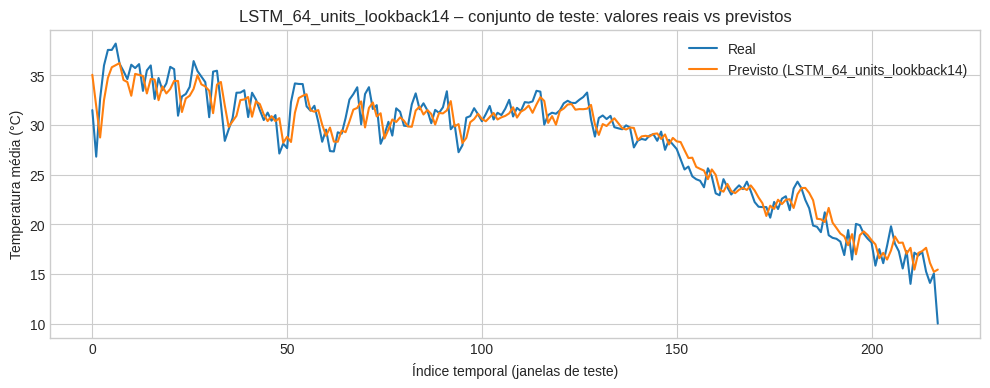

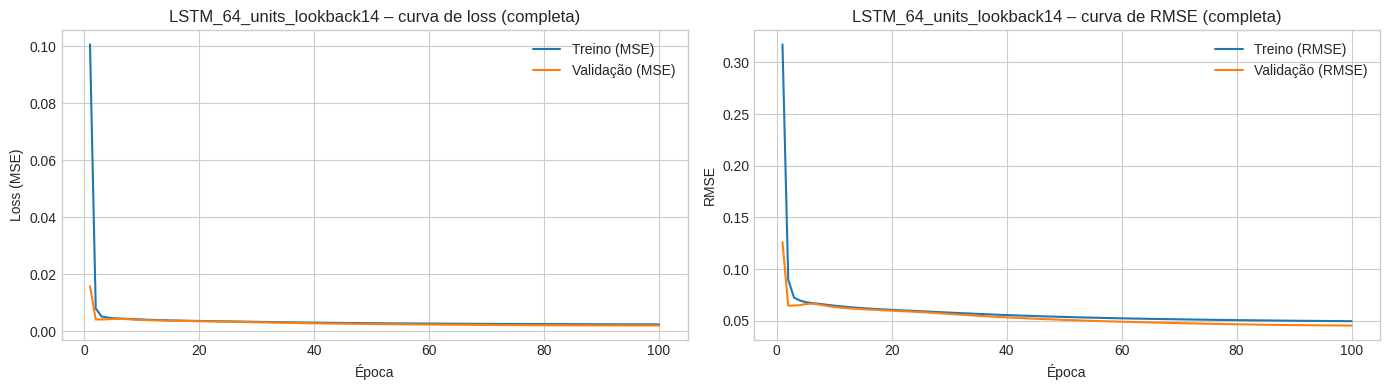


=== Gráficos para LSTM_64_units_lookback60 ===


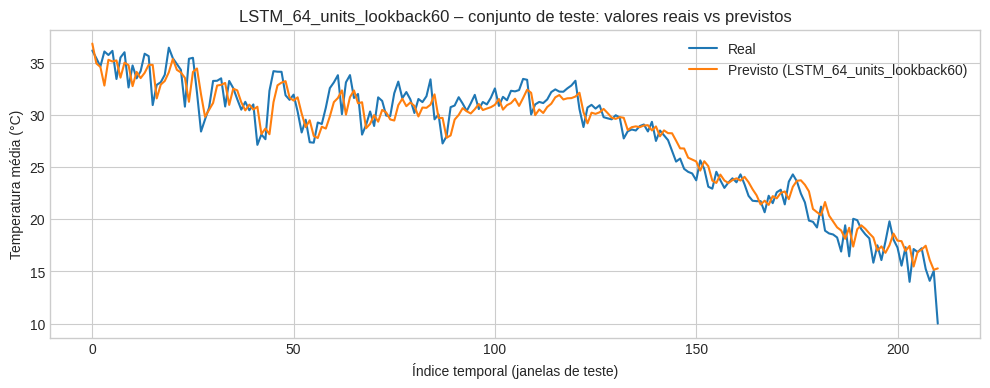

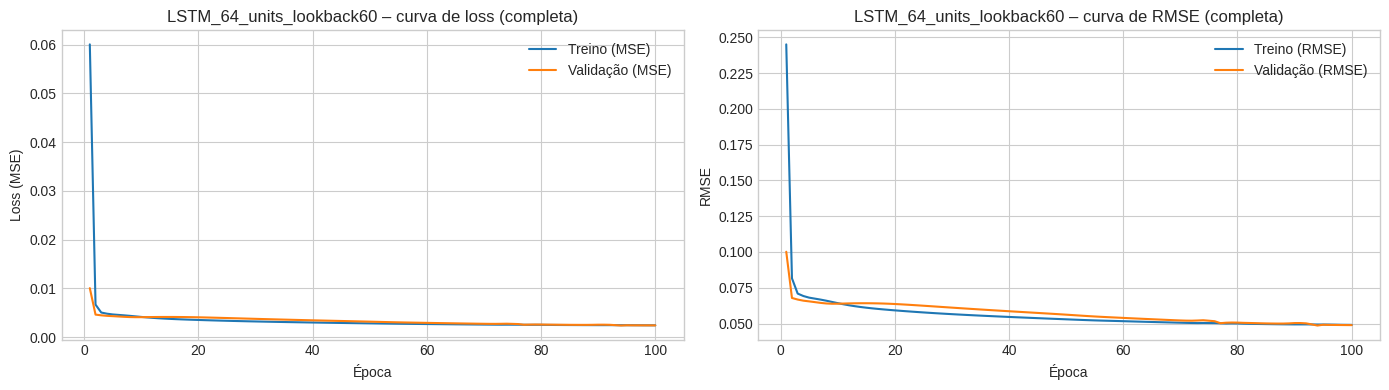

In [ ]:
# Plotar gráficos para os modelos competitivos: lookback 14 e 60 (LSTM 64 unidades)

lookbacks_to_plot = [14, 60]
n_features = X_scaled.shape[1]

for lb in lookbacks_to_plot:
    model_name = f"LSTM_64_units_lookback{lb}"
    print(f"\n=== Gráficos para {model_name} ===")

    # Recuperar modelo e histórico
    model = trained_models[model_name]
    history = model_histories[model_name]

    # Recriar sequências e splits para ESTE lookback
    X_all_lb, y_all_lb = create_multivariate_sequences(X_scaled, y_scaled, lb)

    n_samples_lb = X_all_lb.shape[0]
    train_size = int(n_samples_lb * 0.7)
    val_size = int(n_samples_lb * 0.15)
    test_size = n_samples_lb - train_size - val_size

    X_train = X_all_lb[:train_size]
    y_train = y_all_lb[:train_size]

    X_val = X_all_lb[train_size:train_size + val_size]
    y_val = y_all_lb[train_size:train_size + val_size]

    X_test = X_all_lb[train_size + val_size:]
    y_test = y_all_lb[train_size + val_size:]

    # ---------- 1) Real vs previsto (teste) ----------
    y_test_pred_scaled = model.predict(X_test, verbose=0)

    y_test_true = scaler_y.inverse_transform(y_test)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

    y_test_true_1d = y_test_true.ravel()
    y_test_pred_1d = y_test_pred.ravel()

    plt.figure(figsize=(12, 4))
    plt.plot(y_test_true_1d, label="Real")
    plt.plot(y_test_pred_1d, label=f"Previsto ({model_name})")
    plt.title(f"{model_name} – conjunto de teste: valores reais vs previstos")
    plt.xlabel("Índice temporal (janelas de teste)")
    plt.ylabel("Temperatura média (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ---------- 2) Curvas de loss e RMSE ----------
    epochs = np.arange(1, len(history.history["loss"]) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Loss completo
    axes[0].plot(epochs, history.history["loss"], label="Treino (MSE)")
    axes[0].plot(epochs, history.history["val_loss"], label="Validação (MSE)")
    axes[0].set_title(f"{model_name} – curva de loss (completa)")
    axes[0].set_xlabel("Época")
    axes[0].set_ylabel("Loss (MSE)")
    axes[0].legend()
    axes[0].grid(True)

    # RMSE completo
    axes[1].plot(epochs, history.history["rmse"], label="Treino (RMSE)")
    axes[1].plot(epochs, history.history["val_rmse"], label="Validação (RMSE)")
    axes[1].set_title(f"{model_name} – curva de RMSE (completa)")
    axes[1].set_xlabel("Época")
    axes[1].set_ylabel("RMSE")
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


### 4.6 Comparação dos tamanhos de janela (lookback 14, 30 e 60 dias)

Após fixarmos a arquitetura da rede em uma LSTM com 64 neurônios e uma camada densa de saída, avaliamos o impacto do **tamanho da janela temporal (lookback)** sobre o desempenho do modelo. Testamos três configurações:

- **Lookback = 14 dias (LSTM_64_units_lookback14)**
  - Melhor **val_rmse** entre os três modelos.
  - **test_rmse** ligeiramente melhor que o modelo de 30 dias.
  - Curvas de loss e RMSE (treino vs validação) **suaves e muito próximas**, indicando treinamento estável e boa generalização.
  - Interpretação: janelas mais curtas já fornecem contexto suficiente para prever a temperatura do dia seguinte, com menor complexidade e mais estabilidade na otimização.

- **Lookback = 30 dias (LSTM_64_units)**
  - Desempenho intermediário em validação e teste.
  - Curvas de treino e validação também bem comportadas, sem overfitting relevante.
  - Serve como **baseline estrutural** para comparação com os demais tamanhos de janela.

- **Lookback = 60 dias (LSTM_64_units_lookback60)**
  - **val_rmse superior** (pior) em relação a 14 e 30 dias, embora o **test_rmse tenha ficado ligeiramente melhor**.
  - Curvas de loss e RMSE mais **“ruidosas”**, com pequenas oscilações e trajetória menos suave ao longo do treinamento.
  - Esse comportamento é compatível com:
    - menor número de janelas disponíveis (menos exemplos por época);
    - maior dificuldade de otimização com sequências mais longas;
    - maior sensibilidade à amostragem temporal.
  - Do ponto de vista de seleção baseada em validação, o modelo de 60 dias é mais arriscado e não se justifica como configuração principal.

**Conclusão parcial:**  
Entre as janelas testadas, o **lookback de 14 dias** apresenta o melhor equilíbrio entre desempenho (menor erro em validação e teste), estabilidade do treinamento e simplicidade do modelo. Assim, ele passa a ser nossa **configuração de referência atual**.

No entanto, esta escolha ainda não encerra o processo de ajuste de hiperparâmetros. A partir deste modelo de referência (LSTM com 64 neurônios e lookback 14), continuaremos explorando outros hiperparâmetros relevantes (como *learning rate*, tamanho de batch, eventuais regularizações etc.) para construir uma comparação mais completa entre diferentes configurações da LSTM.


### 4.7 Ajuste conjunto de *learning rate* e número de épocas

Nos experimentos anteriores com lookback de 14 dias e LSTM com 64 neurônios, utilizamos:

- otimizador Adam com `lr = 0.001`;
- limite de **100 épocas**, mas o treinamento vinha até o final sem acionar o *early stopping*.

Isso sugere que o modelo ainda estava melhorando, mesmo que de forma mais lenta nas últimas épocas.  
Simplesmente reduzir o *learning rate* poderia tornar a convergência ainda mais lenta, sem necessariamente atingir um mínimo melhor, se o limite de épocas continuasse em 100.

Para investigar melhor o efeito da taxa de aprendizado, vamos:

- **aumentar o limite de épocas para 200**, mantendo o *early stopping* com `patience = 10`;
- testar diferentes valores de *learning rate* para o Adam, mantendo a arquitetura fixa (LSTM(64), lookback 14, batch_size 32):

  - `lr = 0.0005`  (menor que o padrão)  
  - `lr = 0.0002`  (ainda mais conservador)  
  - `lr = 0.0015`  (ligeiramente maior que o padrão)

Cada configuração será treinada até, no máximo, 200 épocas, com *early stopping* interrompendo antes se `val_loss` parar de melhorar.  
Os modelos serão registrados em `model_results` com nomes que indicam claramente o *learning rate* e o limite de épocas, permitindo comparar diretamente com a configuração de referência (`lr = 0.001`, 100 épocas).


In [ ]:
# Experimentos combinando learning rate menor/maior e 200 épocas
# Arquitetura fixa: LSTM(64), lookback = 14, batch_size = 32

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)

# 1) Garantir sequências e splits para lookback = 14
lookback = 14
n_features = X_scaled.shape[1]

X_all_14, y_all_14 = create_multivariate_sequences(X_scaled, y_scaled, lookback)

n_samples_14 = X_all_14.shape[0]
train_size = int(n_samples_14 * 0.7)
val_size = int(n_samples_14 * 0.15)
test_size = n_samples_14 - train_size - val_size

X_train = X_all_14[:train_size]
y_train = y_all_14[:train_size]

X_val = X_all_14[train_size:train_size + val_size]
y_val = y_all_14[train_size:train_size + val_size]

X_test = X_all_14[train_size + val_size:]
y_test = y_all_14[train_size + val_size:]

print(f"Shapes para lookback={lookback}:")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

# 2) Configurações de learning rate a testar
learning_rates = [0.0005, 0.0002, 0.0015]
epochs = 200
batch_size = 32

# Garantir dicionários para armazenar modelos e históricos
if "trained_models" not in globals():
    trained_models = {}
if "model_histories" not in globals():
    model_histories = {}

for lr in learning_rates:
    print(f"\n=== Treinando LSTM(64) com lookback={lookback}, lr={lr} e até {epochs} épocas ===")

    model = Sequential([
        LSTM(64, input_shape=(lookback, n_features)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=[
            "mae",
            tf.keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    # Salvar modelo e histórico para possíveis gráficos
    model_name = f"LSTM_64_lb14_lr{lr}_ep{epochs}"
    trained_models[model_name] = model
    model_histories[model_name] = history

    # Registrar na tabela global de resultados
    params = {
        "lookback": lookback,
        "units_lstm": 64,
        "batch_size": batch_size,
    }

    results_df = evaluate_and_log_model(
        model,
        history,
        model_name=model_name,
        params=params
    )

print("\nTabela de resultados atualizada após os experimentos de lr + 200 épocas:")
display(results_df)


Shapes para lookback=14:
X_train: (1013, 14, 4) X_val: (217, 14, 4) X_test: (218, 14, 4)

=== Treinando LSTM(64) com lookback=14, lr=0.0005 e até 200 épocas ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1319 - mae: 0.2970 - rmse: 0.3545 - val_loss: 0.0231 - val_mae: 0.1270 - val_rmse: 0.1521
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0171 - mae: 0.1102 - rmse: 0.1305 - val_loss: 0.0056 - val_mae: 0.0589 - val_rmse: 0.0748
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - mae: 0.0651 - rmse: 0.0813 - val_loss: 0.0043 - val_mae: 0.0517 - val_rmse: 0.0658
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - mae: 0.0585 - rmse: 0.0737 - val_loss: 0.0042 - val_mae: 0.0511 - val_rmse: 0.0651
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 - mae: 0.0562 - rmse: 0.0708 - val_loss: 0.0042 - val_mae: 0.0510 - val_rmse: 0.0651
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0047 - mae: 0.0545 - rmse: 0.0687 - val_loss: 0.0043 - val_mae: 0.0513 - val_rmse: 0.0655
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0045 - mae: 0.0534 - rmse: 0.0674 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868



=== Treinando LSTM(64) com lookback=14, lr=0.0002 e até 200 épocas ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1387 - mae: 0.3226 - rmse: 0.3684 - val_loss: 0.0426 - val_mae: 0.1837 - val_rmse: 0.2063
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0232 - mae: 0.1239 - rmse: 0.1524 - val_loss: 0.0205 - val_mae: 0.1219 - val_rmse: 0.1431
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - mae: 0.0859 - rmse: 0.1071 - val_loss: 0.0093 - val_mae: 0.0814 - val_rmse: 0.0966
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - mae: 0.0633 - rmse: 0.0788 - val_loss: 0.0059 - val_mae: 0.0627 - val_rmse: 0.0766
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0053 - mae: 0.0582 - rmse: 0.0726 - val_loss: 0.0054 - val_mae: 0.0594 - val_rmse: 0.0736
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0051 - mae: 0.0572 - rmse: 0.0715 - val_loss: 0.0052 - val_mae: 0.0581 - val_rmse: 0.0721
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - mae: 0.0561 - rmse: 0.0703 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092



=== Treinando LSTM(64) com lookback=14, lr=0.0015 e até 200 épocas ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0526 - mae: 0.1792 - rmse: 0.2224 - val_loss: 0.0077 - val_mae: 0.0708 - val_rmse: 0.0876
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0060 - mae: 0.0622 - rmse: 0.0776 - val_loss: 0.0044 - val_mae: 0.0525 - val_rmse: 0.0665
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - mae: 0.0513 - rmse: 0.0650 - val_loss: 0.0041 - val_mae: 0.0502 - val_rmse: 0.0637
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0039 - mae: 0.0495 - rmse: 0.0627 - val_loss: 0.0038 - val_mae: 0.0487 - val_rmse: 0.0617
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 - mae: 0.0482 - rmse: 0.0609 - val_loss: 0.0037 - val_mae: 0.0478 - val_rmse: 0.0607
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - mae: 0.0471 - rmse: 0.0597 - val_loss: 0.0036 - val_mae: 0.0473 - val_rmse: 0.0601
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - mae: 0.0462 - rmse: 0.0588 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060



Tabela de resultados atualizada após os experimentos de lr + 200 épocas:


,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060



=== Gráficos de loss para LSTM_64_lb14_lr0.0005_ep200 ===


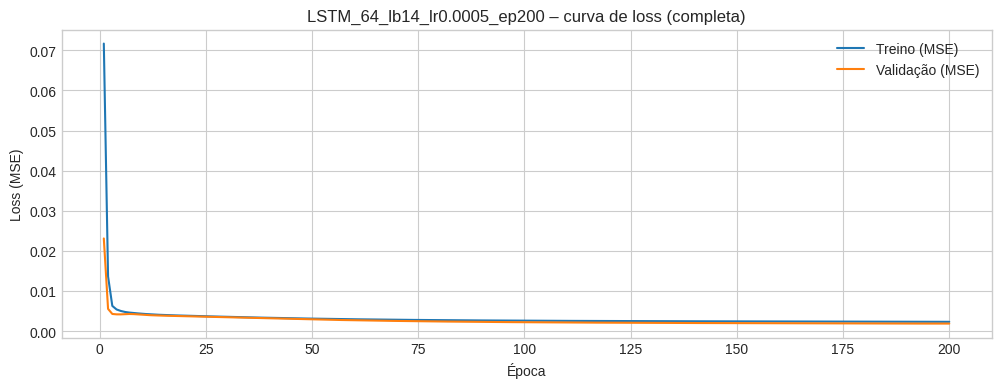

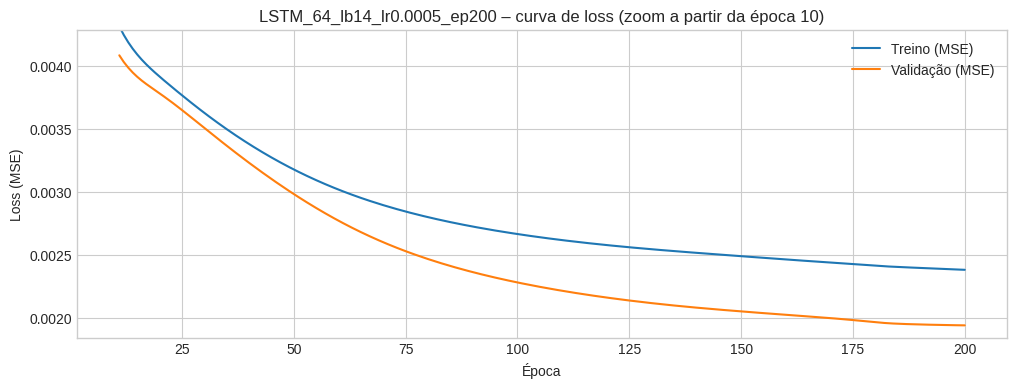


=== Gráficos de loss para LSTM_64_lb14_lr0.0002_ep200 ===


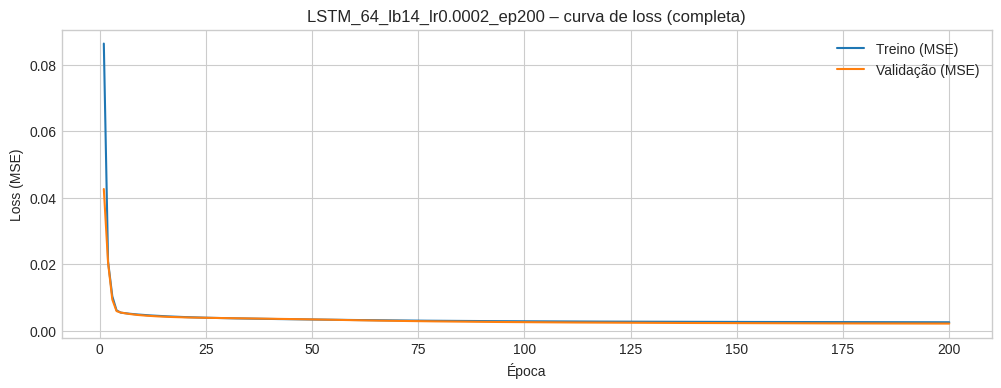

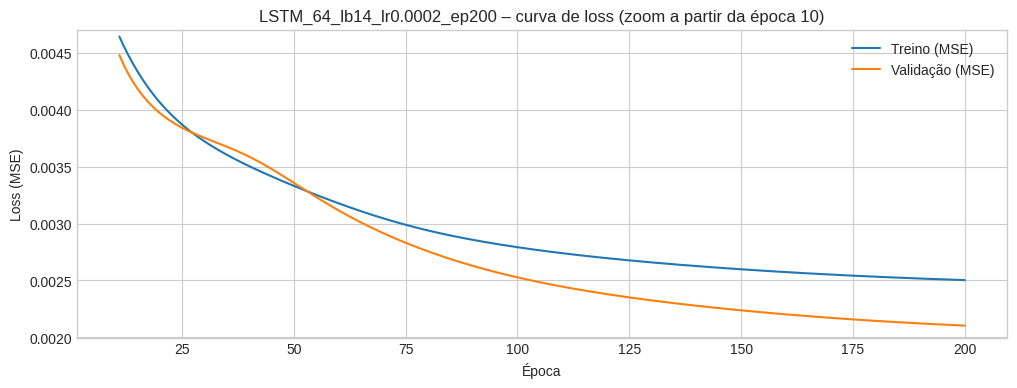


=== Gráficos de loss para LSTM_64_lb14_lr0.0015_ep200 ===


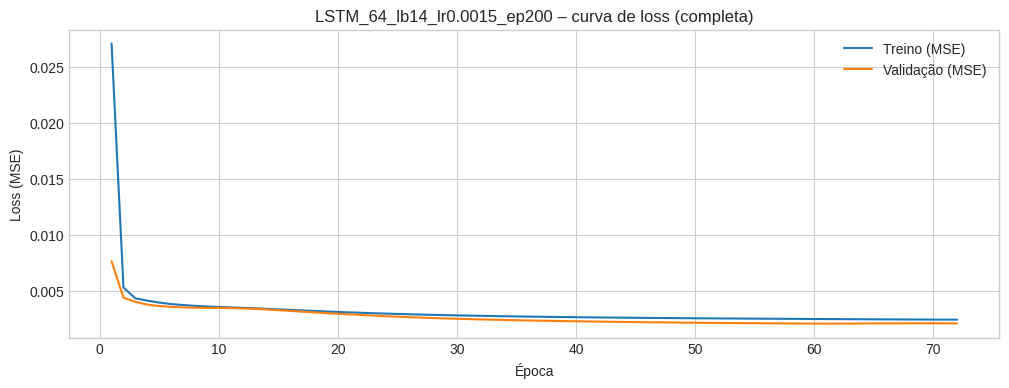

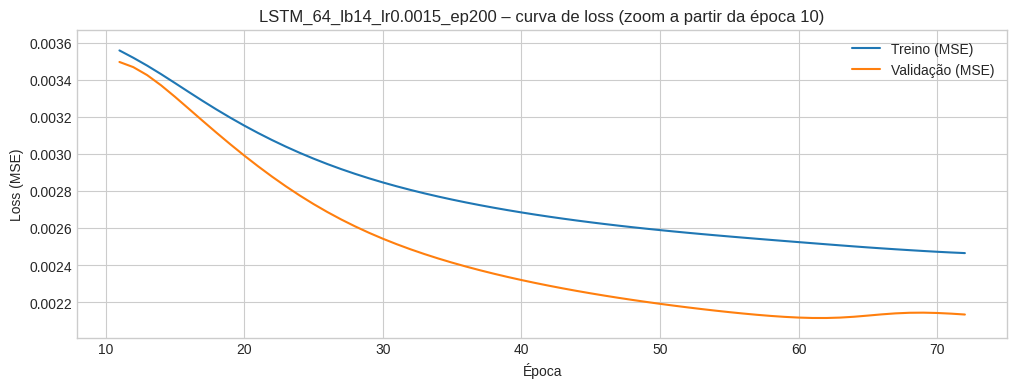

In [ ]:
# Gráficos de loss (MSE) para os modelos com lookback=14, LSTM(64) e diferentes learning rates

import numpy as np
import matplotlib.pyplot as plt

model_names_lr = [
    "LSTM_64_lb14_lr0.0005_ep200",
    "LSTM_64_lb14_lr0.0002_ep200",
    "LSTM_64_lb14_lr0.0015_ep200",
]

zoom_start = 10  # a partir de qual época queremos dar zoom

for name in model_names_lr:
    if name not in model_histories:
        print(f"Aviso: histórico não encontrado para {name}")
        continue

    history = model_histories[name]
    losses = history.history["loss"]
    val_losses = history.history["val_loss"]
    epochs = np.arange(1, len(losses) + 1)

    print(f"\n=== Gráficos de loss para {name} ===")

    # Figura 1 – curva completa de loss
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, losses, label="Treino (MSE)")
    plt.plot(epochs, val_losses, label="Validação (MSE)")
    plt.title(f"{name} – curva de loss (completa)")
    plt.xlabel("Época")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Figura 2 – zoom nas últimas épocas
    plt.figure(figsize=(12, 4))
    plt.plot(epochs[zoom_start:], losses[zoom_start:], label="Treino (MSE)")
    plt.plot(epochs[zoom_start:], val_losses[zoom_start:], label="Validação (MSE)")
    plt.title(f"{name} – curva de loss (zoom a partir da época {zoom_start})")
    plt.xlabel("Época")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)

    # Ajuste automático dos limites de y com pequena margem
    val_slice = val_losses[zoom_start:]
    ymin, ymax = min(val_slice), max(val_slice)
    plt.ylim(ymin * 0.95, ymax * 1.05)

    plt.show()


### 4.7 Exploração do tamanho do batch (batch_size)

Após ajustar o *learning rate*, nosso modelo de referência atual é:

- LSTM com **64 neurônios** (uma camada);
- **lookback = 14 dias**;
- otimizador **Adam** com `lr = 0.0005`;
- **máximo de 200 épocas**, com *early stopping* (`patience = 10`);
- `batch_size = 32`.

O próximo hiperparâmetro a ser investigado é o **tamanho do batch**.  
O batch size controla quantos exemplos são usados em cada atualização de gradiente:

- **batches menores (por exemplo, 16)** introduzem mais **ruído** na estimativa do gradiente, o que às vezes ajuda a escapar de mínimos ruins e pode melhorar a generalização, ao custo de mais atualizações por época.
- **batches maiores (por exemplo, 64)** produzem gradientes mais “limpos” e estáveis, mas podem levar o modelo a mínimos menos variados, com risco de pior generalização.

Para avaliar esse efeito, manteremos **todos os outros hiperparâmetros fixos** (arquitetura, lookback, lr, épocas, early stopping) e treinaremos dois novos modelos:

- `batch_size = 16`
- `batch_size = 64`

Cada modelo será treinado com o mesmo esquema de validação e registrado na tabela `model_results`, permitindo comparar diretamente o impacto do tamanho do batch sobre as métricas (`val_rmse`, `test_rmse`) e o comportamento das curvas de loss.


In [ ]:
# Experimentos de batch_size com modelo "campeão":
# LSTM(64), lookback=14, lr=0.0005, epochs_max=200

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)

# Garantir sequências/splits para lookback = 14 (reutilizando o que já usamos)
lookback = 14
n_features = X_scaled.shape[1]

X_all_14, y_all_14 = create_multivariate_sequences(X_scaled, y_scaled, lookback)

n_samples_14 = X_all_14.shape[0]
train_size = int(n_samples_14 * 0.7)
val_size = int(n_samples_14 * 0.15)
test_size = n_samples_14 - train_size - val_size

X_train = X_all_14[:train_size]
y_train = y_all_14[:train_size]

X_val = X_all_14[train_size:train_size + val_size]
y_val = y_all_14[train_size:train_size + val_size]

X_test = X_all_14[train_size + val_size:]
y_test = y_all_14[train_size + val_size:]

print(f"Shapes para lookback={lookback}:")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

batch_sizes = [16, 64]
epochs = 200
lr = 0.0005

if "trained_models" not in globals():
    trained_models = {}
if "model_histories" not in globals():
    model_histories = {}

for bs in batch_sizes:
    print(f"\n=== Treinando LSTM(64) com lookback={lookback}, lr={lr}, batch_size={bs} ===")

    model = Sequential([
        LSTM(64, input_shape=(lookback, n_features)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=[
            "mae",
            tf.keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=bs,
        callbacks=[early_stopping],
        verbose=1
    )

    model_name = f"LSTM_64_lb14_lr{lr}_bs{bs}_ep{epochs}"
    trained_models[model_name] = model
    model_histories[model_name] = history

    params = {
        "lookback": lookback,
        "units_lstm": 64,
        "batch_size": bs,
    }

    results_df = evaluate_and_log_model(
        model,
        history,
        model_name=model_name,
        params=params
    )

print("\nTabela de resultados atualizada após os experimentos de batch_size:")
display(results_df)


Shapes para lookback=14:
X_train: (1013, 14, 4) X_val: (217, 14, 4) X_test: (218, 14, 4)

=== Treinando LSTM(64) com lookback=14, lr=0.0005, batch_size=16 ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1999 - mae: 0.3579 - rmse: 0.4296 - val_loss: 0.0084 - val_mae: 0.0737 - val_rmse: 0.0918
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - mae: 0.0591 - rmse: 0.0740 - val_loss: 0.0046 - val_mae: 0.0528 - val_rmse: 0.0675
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - mae: 0.0551 - rmse: 0.0695 - val_loss: 0.0049 - val_mae: 0.0554 - val_rmse: 0.0698
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - mae: 0.0539 - rmse: 0.0684 - val_loss: 0.0051 - val_mae: 0.0572 - val_rmse: 0.0714
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - mae: 0.0532 - rmse: 0.0675 - val_loss: 0.0052 - val_mae: 0.0577 - val_rmse: 0.0718
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mae: 0.0525 - rmse: 0.0666 - val_loss: 0.0051 - val_mae: 0.0578 - val_rmse: 0.0717
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - mae: 0.0519 - rmse: 0.0658 - val_loss:

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588



=== Treinando LSTM(64) com lookback=14, lr=0.0005, batch_size=64 ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.3073 - mae: 0.5102 - rmse: 0.5486 - val_loss: 0.0197 - val_mae: 0.1128 - val_rmse: 0.1402
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - mae: 0.1094 - rmse: 0.1340 - val_loss: 0.0164 - val_mae: 0.1087 - val_rmse: 0.1279
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - mae: 0.0784 - rmse: 0.0969 - val_loss: 0.0081 - val_mae: 0.0710 - val_rmse: 0.0899
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0066 - mae: 0.0659 - rmse: 0.0810 - val_loss: 0.0050 - val_mae: 0.0558 - val_rmse: 0.0704
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - mae: 0.0528 - rmse: 0.0655 - val_loss: 0.0037 - val_mae: 0.0478 - val_rmse: 0.0611
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - mae: 0.0509 - rmse: 0.0645 - val_loss: 0.0036 - val_mae: 0.0467 - val_rmse: 0.0602
Epoch 7/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - mae: 0.0503 - rmse: 0.0633 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588



Tabela de resultados atualizada após os experimentos de batch_size:


,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588


### 4.8 Resultados do ajuste de batch size e decisão de manter a configuração original

Testamos o impacto do **batch_size** mantendo fixos os demais hiperparâmetros do nosso melhor modelo até aqui:

- Arquitetura: LSTM com 64 neurônios + camada densa
- Lookback: 14 dias
- Learning rate: 0.0005 (Adam)
- Máximo de 200 épocas, com early stopping (patience = 10)

Foram avaliados:

- `batch_size = 16`
- `batch_size = 64`

Os resultados mostraram uma **piora consistente** em relação ao modelo de referência (`batch_size = 32`):

- `val_rmse` aumentou em ambos os casos;
- `test_rmse` também ficou significativamente pior;
- as métricas de treino indicam que a mudança de batch não trouxe nenhuma vantagem em termos de otimização.

Diante disso, concluímos que, para esta combinação de dados e arquitetura, **`batch_size = 32` continua sendo a melhor escolha**.  


### 4.9 Teste de regularização com dropout na LSTM

Até aqui, o nosso melhor modelo é:

- LSTM com **64 unidades**
- **lookback = 14** dias
- otimizador Adam com **lr = 0.0005**
- até **200 épocas**, com early stopping (`patience = 10`)
- `batch_size = 32`

As curvas de loss de treino e validação são bastante próximas, sem sinais fortes de overfitting.  
Ainda assim, do ponto de vista de modelagem, é importante verificar se alguma forma leve de regularização pode:

- melhorar ligeiramente a capacidade de generalização, ou
- pelo menos confirmar que, neste conjunto de dados, o uso de dropout não traz benefícios.

Nesta etapa, vamos testar **dropout na camada LSTM**, mantendo todos os demais hiperparâmetros fixos:

- Modelo A: `dropout = 0.2`
- Modelo B: `dropout = 0.4`

A expectativa é que, se o modelo já não está sobreajustando, o dropout tenda a:

- manter o desempenho semelhante, ou
- piorar um pouco as métricas, por reduzir a capacidade efetiva da rede.

Os resultados serão registrados na tabela `model_results` e servirão para documentar no relatório que a regularização foi investigada de forma sistemática.


In [ ]:
# Experimentos de dropout na LSTM, mantendo a melhor configuração atual:
# LSTM(64), lookback=14, lr=0.0005, epochs_max=200, batch_size=32

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)

lookback = 14
n_features = X_scaled.shape[1]

# Recriar sequências e splits para lookback=14
X_all_14, y_all_14 = create_multivariate_sequences(X_scaled, y_scaled, lookback)

n_samples_14 = X_all_14.shape[0]
train_size = int(n_samples_14 * 0.7)
val_size = int(n_samples_14 * 0.15)
test_size = n_samples_14 - train_size - val_size

X_train = X_all_14[:train_size]
y_train = y_all_14[:train_size]

X_val = X_all_14[train_size:train_size + val_size]
y_val = y_all_14[train_size:train_size + val_size]

X_test = X_all_14[train_size + val_size:]
y_test = y_all_14[train_size + val_size:]

print(f"Shapes para lookback={lookback}:")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

dropout_values = [0.2, 0.4]
epochs = 200
batch_size = 32
lr = 0.0005

if "trained_models" not in globals():
    trained_models = {}
if "model_histories" not in globals():
    model_histories = {}

for dp in dropout_values:
    print(f"\n=== Treinando LSTM(64) com dropout={dp}, lookback={lookback}, lr={lr}, bs={batch_size} ===")

    model = Sequential([
        LSTM(64, dropout=dp, input_shape=(lookback, n_features)),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=[
            "mae",
            tf.keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    model_name = f"LSTM_64_lb14_lr{lr}_bs{batch_size}_drop{dp}_ep{epochs}"
    trained_models[model_name] = model
    model_histories[model_name] = history

    params = {
        "lookback": lookback,
        "units_lstm": 64,
        "batch_size": batch_size,
        "dropout": dp
    }

    results_df = evaluate_and_log_model(
        model,
        history,
        model_name=model_name,
        params=params
    )

print("\nTabela de resultados atualizada após os experimentos com dropout:")
display(results_df)


Shapes para lookback=14:
X_train: (1013, 14, 4) X_val: (217, 14, 4) X_test: (218, 14, 4)

=== Treinando LSTM(64) com dropout=0.2, lookback=14, lr=0.0005, bs=32 ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.2973 - mae: 0.4679 - rmse: 0.5346 - val_loss: 0.0564 - val_mae: 0.1949 - val_rmse: 0.2376
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0478 - mae: 0.1645 - rmse: 0.2185 - val_loss: 0.0400 - val_mae: 0.1577 - val_rmse: 0.2000
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0419 - mae: 0.1512 - rmse: 0.2045 - val_loss: 0.0392 - val_mae: 0.1509 - val_rmse: 0.1979
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0361 - mae: 0.1395 - rmse: 0.1898 - val_loss: 0.0307 - val_mae: 0.1336 - val_rmse: 0.1751
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0303 - mae: 0.1288 - rmse: 0.1741 - val_loss: 0.0278 - val_mae: 0.1279 - val_rmse: 0.1667
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0265 - mae: 0.1248 - rmse: 0.1623 - val_loss: 0.0241 - val_mae: 0.1170 - val_rmse: 0.1551
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0273 - mae: 0.1220 - rmse: 0.1650 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588



=== Treinando LSTM(64) com dropout=0.4, lookback=14, lr=0.0005, bs=32 ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.1295 - mae: 0.2991 - rmse: 0.3575 - val_loss: 0.0503 - val_mae: 0.1744 - val_rmse: 0.2243
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0574 - mae: 0.1825 - rmse: 0.2395 - val_loss: 0.0397 - val_mae: 0.1551 - val_rmse: 0.1993
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0401 - mae: 0.1604 - rmse: 0.2003 - val_loss: 0.0340 - val_mae: 0.1487 - val_rmse: 0.1844
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0355 - mae: 0.1485 - rmse: 0.1883 - val_loss: 0.0304 - val_mae: 0.1384 - val_rmse: 0.1744
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0320 - mae: 0.1435 - rmse: 0.1788 - val_loss: 0.0313 - val_mae: 0.1397 - val_rmse: 0.1769
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0274 - mae: 0.1320 - rmse: 0.1654 - val_loss: 0.0192 - val_mae: 0.1069 - val_rmse: 0.1387
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0244 - mae: 0.1202 - rmse: 0.1561 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588



Tabela de resultados atualizada após os experimentos com dropout:


,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588


### 4.10 Conclusão sobre o uso de dropout na LSTM

Testamos a inclusão de **dropout** na camada LSTM do nosso melhor modelo atual:

- Arquitetura base: LSTM(64) → Dense(1)
- Lookback = 14 dias
- Adam `lr = 0.0005`
- Máx. 200 épocas, early stopping (`patience = 10`)
- `batch_size = 32`
- Dropout testados: `0.2` e `0.4`

Os resultados foram significativamente piores:

- A **`val_rmse` aumentou de ~1.44 (modelo sem dropout)** para valores acima de 2 e 4, respectivamente.
- As métricas de treino (`train_mae`, `train_rmse`) também pioraram, indicando que o modelo perdeu capacidade de ajuste mesmo no conjunto de treinamento.
- Ou seja, o dropout não apenas não ajudou a combater overfitting (que já era baixo), como **reduziu a capacidade de aprendizado da rede** neste conjunto de dados.

Com isso, consolidamos que, para esta série temporal específica e com o tamanho de rede adotado, **não faz sentido utilizar dropout na LSTM**. O modelo de referência segue sendo:

- **LSTM(64), lookback 14, lr = 0.0005, batch_size 32, sem dropout, até 200 épocas.**

Como próximo passo, em vez de adicionar mais camadas recorrentes (o que já vimos que piora o desempenho), vamos testar uma **camada densa intermediária após a LSTM**, mantendo a mesma configuração de hiperparâmetros:

- Arquiteturas a avaliar:
  - LSTM(64) → Dense(32, ReLU) → Dense(1)
  - LSTM(64) → Dense(16, ReLU) → Dense(1)

A ideia é verificar se uma camada totalmente conectada adicional, operando sobre a saída temporal agregada da LSTM, consegue capturar melhor relações não lineares entre as features extraídas pela LSTM e a temperatura alvo, **sem aumentar demais a complexidade recorrente**.


In [ ]:
# Experimentos com camada densa intermediária após a LSTM
# Base: LSTM(64), lookback=14, lr=0.0005, epochs_max=200, batch_size=32, sem dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

tf.random.set_seed(42)

lookback = 14
n_features = X_scaled.shape[1]

# Recriar sequências e splits para lookback=14
X_all_14, y_all_14 = create_multivariate_sequences(X_scaled, y_scaled, lookback)

n_samples_14 = X_all_14.shape[0]
train_size = int(n_samples_14 * 0.7)
val_size = int(n_samples_14 * 0.15)
test_size = n_samples_14 - train_size - val_size

X_train = X_all_14[:train_size]
y_train = y_all_14[:train_size]

X_val = X_all_14[train_size:train_size + val_size]
y_val = y_all_14[train_size:train_size + val_size]

X_test = X_all_14[train_size + val_size:]
y_test = y_all_14[train_size + val_size:]

print(f"Shapes para lookback={lookback}:")
print("X_train:", X_train.shape, "X_val:", X_val.shape, "X_test:", X_test.shape)

dense_units_list = [16, 32]
epochs = 200
batch_size = 32
lr = 0.0005

if "trained_models" not in globals():
    trained_models = {}
if "model_histories" not in globals():
    model_histories = {}

for du in dense_units_list:
    print(f"\n=== Treinando LSTM(64) + Dense({du}) com lookback={lookback}, lr={lr}, bs={batch_size} ===")

    model = Sequential([
        LSTM(64, input_shape=(lookback, n_features)),
        Dense(du, activation="relu"),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=[
            "mae",
            tf.keras.metrics.RootMeanSquaredError(name="rmse")
        ]
    )

    early_stopping = EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping],
        verbose=1
    )

    model_name = f"LSTM_64_lb14_lr{lr}_bs{batch_size}_dense{du}_ep{epochs}"
    trained_models[model_name] = model
    model_histories[model_name] = history

    params = {
        "lookback": lookback,
        "units_lstm": 64,
        "batch_size": batch_size,
        "dense_units": du
    }

    results_df = evaluate_and_log_model(
        model,
        history,
        model_name=model_name,
        params=params
    )




Shapes para lookback=14:
X_train: (1013, 14, 4) X_val: (217, 14, 4) X_test: (218, 14, 4)

=== Treinando LSTM(64) + Dense(16) com lookback=14, lr=0.0005, bs=32 ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.2441 - mae: 0.4281 - rmse: 0.4849 - val_loss: 0.0231 - val_mae: 0.1292 - val_rmse: 0.1518
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - mae: 0.0862 - rmse: 0.1059 - val_loss: 0.0042 - val_mae: 0.0520 - val_rmse: 0.0650
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0049 - mae: 0.0550 - rmse: 0.0697 - val_loss: 0.0038 - val_mae: 0.0479 - val_rmse: 0.0613
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041 - mae: 0.0505 - rmse: 0.0638 - val_loss: 0.0039 - val_mae: 0.0489 - val_rmse: 0.0623
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0040 - mae: 0.0496 - rmse: 0.0629 - val_loss: 0.0039 - val_mae: 0.0491 - val_rmse: 0.0625
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - mae: 0.0490 - rmse: 0.0621 - val_loss: 0.0040 - val_mae: 0.0497 - val_rmse: 0.0629
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0038 - mae: 0.0485 - rmse: 0.0616 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588



=== Treinando LSTM(64) + Dense(32) com lookback=14, lr=0.0005, bs=32 ===
Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.1915 - mae: 0.3682 - rmse: 0.4286 - val_loss: 0.0343 - val_mae: 0.1614 - val_rmse: 0.1851
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0213 - mae: 0.1210 - rmse: 0.1460 - val_loss: 0.0125 - val_mae: 0.0928 - val_rmse: 0.1119
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - mae: 0.0714 - rmse: 0.0888 - val_loss: 0.0042 - val_mae: 0.0512 - val_rmse: 0.0646
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - mae: 0.0566 - rmse: 0.0716 - val_loss: 0.0042 - val_mae: 0.0510 - val_rmse: 0.0646
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0048 - mae: 0.0547 - rmse: 0.0690 - val_loss: 0.0043 - val_mae: 0.0517 - val_rmse: 0.0654
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - mae: 0.0537 - rmse: 0.0678 - val_loss: 0.0043 - val_mae: 0.0522 - val_rmse: 0.0658
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0045 - mae: 0.0532 - rmse: 0.0672 - val_loss

,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588



Tabela de resultados atualizada após os experimentos com camada densa intermediária:


,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588


Shapes (lookback=14): X_train: (1013, 14, 4) X_val: (217, 14, 4) X_test: (218, 14, 4)

=== Gráficos para LSTM_64_lb14_lr0.0005_bs32_dense16_ep200 ===


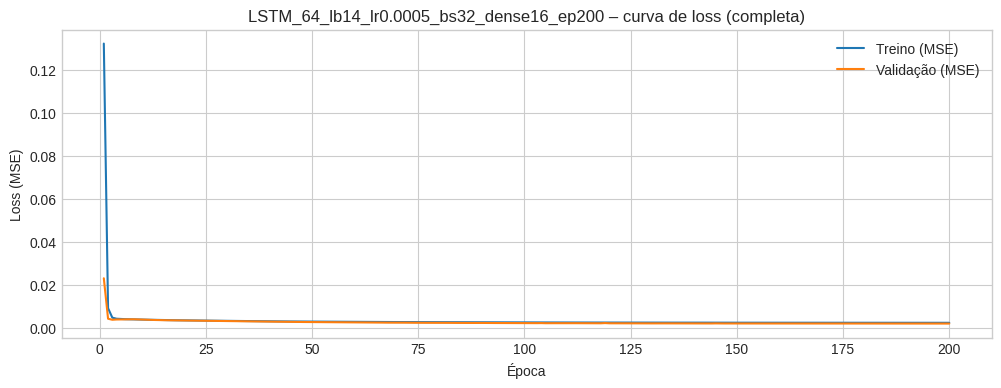

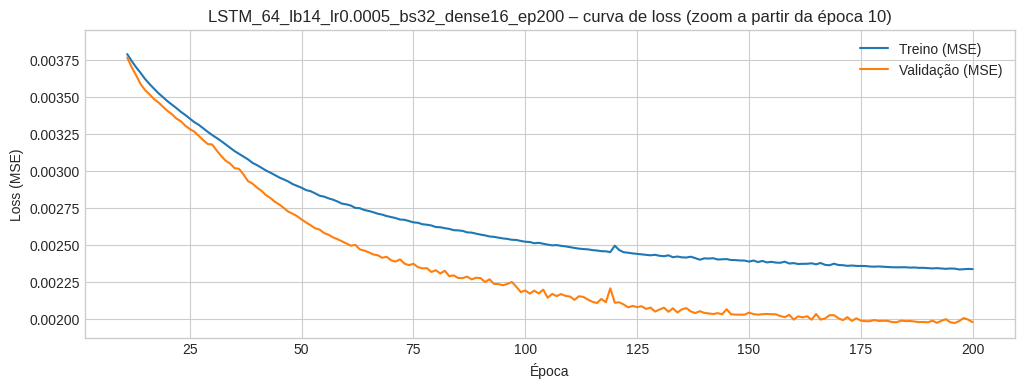


=== Gráficos para LSTM_64_lb14_lr0.0005_bs32_dense32_ep200 ===


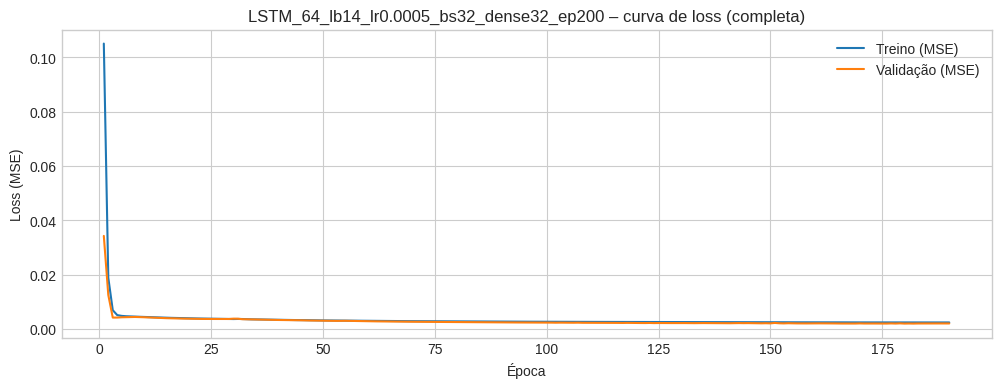

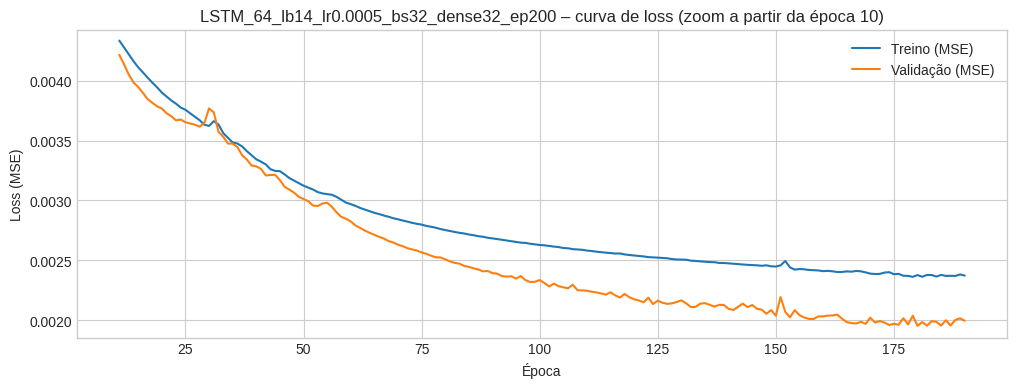

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Nomes dos modelos com camada densa intermediária
dense_models = [
    "LSTM_64_lb14_lr0.0005_bs32_dense16_ep200",
    "LSTM_64_lb14_lr0.0005_bs32_dense32_ep200",
]

lookback = 14
n_features = X_scaled.shape[1]
zoom_start = 10  # a partir de qual época queremos o zoom nos gráficos de loss

# Recriar sequências e splits para lookback=14 (mesmo split usado antes)
X_all_14, y_all_14 = create_multivariate_sequences(X_scaled, y_scaled, lookback)

n_samples_14 = X_all_14.shape[0]
train_size = int(n_samples_14 * 0.7)
val_size = int(n_samples_14 * 0.15)
test_size = n_samples_14 - train_size - val_size

X_train = X_all_14[:train_size]
y_train = y_all_14[:train_size]

X_val = X_all_14[train_size:train_size + val_size]
y_val = y_all_14[train_size:train_size + val_size]

X_test = X_all_14[train_size + val_size:]
y_test = y_all_14[train_size + val_size:]

print("Shapes (lookback=14):",
      "X_train:", X_train.shape,
      "X_val:", X_val.shape,
      "X_test:", X_test.shape)

for name in dense_models:
    if name not in trained_models or name not in model_histories:
        print(f"Aviso: modelo ou histórico não encontrado para {name}")
        continue

    model = trained_models[name]
    history = model_histories[name]

    print(f"\n=== Gráficos para {name} ===")

    # ---------- 2) Curvas de loss (MSE) ----------
    losses = history.history["loss"]
    val_losses = history.history["val_loss"]
    epochs = np.arange(1, len(losses) + 1)

    # 2.1 – curva completa
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, losses, label="Treino (MSE)")
    plt.plot(epochs, val_losses, label="Validação (MSE)")
    plt.title(f"{name} – curva de loss (completa)")
    plt.xlabel("Época")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2.2 – zoom a partir de uma época (para ver detalhes)
    plt.figure(figsize=(12, 4))
    plt.plot(epochs[zoom_start:], losses[zoom_start:], label="Treino (MSE)")
    plt.plot(epochs[zoom_start:], val_losses[zoom_start:], label="Validação (MSE)")
    plt.title(f"{name} – curva de loss (zoom a partir da época {zoom_start})")
    plt.xlabel("Época")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)

    val_slice = val_losses[zoom_start:]
    ymin, ymax = min(val_slice), max(val_slice)
    plt.ylim(ymin * 0.95, ymax * 1.05)

    plt.show()


### 4.11 Escolha do modelo final e análise das arquiteturas testadas

Após a sequência de experimentos, o modelo que adotamos como **modelo final** é:

- **Arquitetura:** 1 camada LSTM com **64 unidades** → Dense(1)  
- **Lookback:** 14 dias  
- **Otimizador:** Adam, `learning_rate = 0.0005`  
- **Treino:** até 200 épocas, com *early stopping* (`patience = 10`)  
- **Batch size:** 32  
- **Sem dropout e sem camada densa intermediária**

Esse modelo apresentou o melhor compromisso entre **desempenho**, **estabilidade** e **complexidade**.  
Os principais argumentos são:

1. **Desempenho em validação**  
   - O modelo LSTM(64) simples obteve o menor **`val_rmse`** entre todas as combinações testadas  
     (variações de unidades, número de camadas, lookback, learning rate, batch size, dropout e camada densa intermediária).
   - Os modelos com camada densa extra (Dense(16) e Dense(32)) chegaram perto em termos numéricos, mas **não superaram de forma consistente** o `val_rmse` do modelo simples.

2. **Comportamento das curvas de loss (overfitting local)**  
   - No modelo LSTM(64) simples, as curvas de **loss de treino e validação** são suaves, próximas entre si e sem oscilações bruscas, o que indica **boa generalização** e pouca variância.
   - Já nos modelos com **camada densa intermediária**, as curvas de validação apresentam **mais “spikes” e serrilhados**:  
     há vários trechos em que o loss de treino continua caindo enquanto o loss de validação **sobe temporariamente**.  
     Esse padrão é compatível com **overfitting local** (o modelo começa a se ajustar a ruídos do conjunto de treino), mesmo sem explosões de erro.
   - Ou seja, além de não trazer melhora clara nas métricas, esses modelos tornam o treinamento **mais instável** do ponto de vista da validação.

3. **Parcimônia (modelo mais simples que resolve bem o problema)**  
   - As arquiteturas com mais camadas (LSTM empilhada) ou com camada densa intermediária têm **mais parâmetros** e, portanto, maior risco de overfitting e maior custo computacional.
   - Como o ganho de desempenho não se concretizou e as curvas de validação ficam mais ruidosas, optamos por **não aumentar a complexidade do modelo sem necessidade**.

Com base nesses pontos, o restante da análise (avaliação detalhada, gráficos finais de previsão vs valores reais, análise de resíduos e discussão dos resultados) será conduzido utilizando **o modelo LSTM(64) com lookback 14, lr = 0.0005, batch_size 32, sem dropout e sem camada densa extra**, tratando as demais variantes apenas como **experimentos de apoio** para justificar as decisões de modelagem.


In [ ]:
# Finalizando mostrando toda a tabela de modelos:
print('Tabela final de modelos:')
display(results_df)

Tabela final de modelos:


,model,lookback,units_lstm,batch_size,epochs_trained,best_val_loss,train_mae,train_rmse,val_mae,val_rmse,test_mae,test_rmse
0,LSTM_baseline,30,32,32,100,0.002147,1.200439,1.569825,1.173620,1.515928,1.310341,1.630812
1,LSTM_64_units,30,64,32,100,0.002084,1.205125,1.576592,1.133447,1.493316,1.278022,1.611759
2,LSTM_stacked_64_32,30,64-32,32,17,0.004750,1.744954,2.218404,1.788025,2.254607,1.750160,2.176637
3,LSTM_128_units,30,128,32,66,0.002307,1.265744,1.617944,1.218731,1.571276,1.325435,1.643316
4,LSTM_64_units_lookback14,14,64,32,100,0.002070,1.228011,1.595885,1.145208,1.488538,1.248897,1.605519
5,LSTM_64_units_lookback60,60,64,32,100,0.002361,1.196512,1.576146,1.221128,1.589461,1.219510,1.535588
6,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,0.001939,1.203876,1.571256,1.106028,1.440719,1.276443,1.626868
7,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,0.002104,1.238011,1.612500,1.141110,1.500574,1.238019,1.616092
8,LSTM_64_lb14_lr0.0015_ep200,14,64,32,72,0.002115,1.246494,1.608634,1.150143,1.504576,1.249795,1.598060
9,LSTM_64_lb14_lr0.0005_bs16_ep200,14,64,16,12,0.004552,1.874120,2.358989,1.726797,2.207262,1.810834,2.273588


Top 5 modelos realmente disponíveis (ordenados por val_rmse):


,model,lookback,units_lstm,batch_size,epochs_trained,val_rmse,test_rmse
0,LSTM_64_lb14_lr0.0005_ep200,14,64,32,200,1.440719,1.626868
1,LSTM_64_lb14_lr0.0005_bs32_dense32_ep200,14,64,32,190,1.445774,1.622230
2,LSTM_64_lb14_lr0.0005_bs32_dense16_ep200,14,64,32,200,1.452959,1.637846
3,LSTM_64_units_lookback14,14,64,32,100,1.488538,1.605519
4,LSTM_64_lb14_lr0.0002_ep200,14,64,32,200,1.500574,1.616092



=== Modelo #1: LSTM_64_lb14_lr0.0005_ep200 (lookback=14) ===


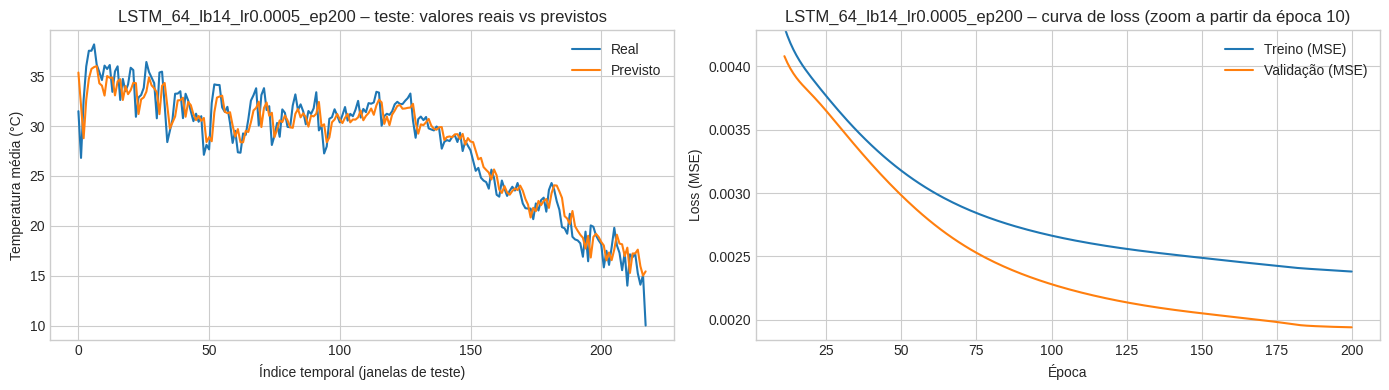


=== Modelo #2: LSTM_64_lb14_lr0.0005_bs32_dense32_ep200 (lookback=14) ===


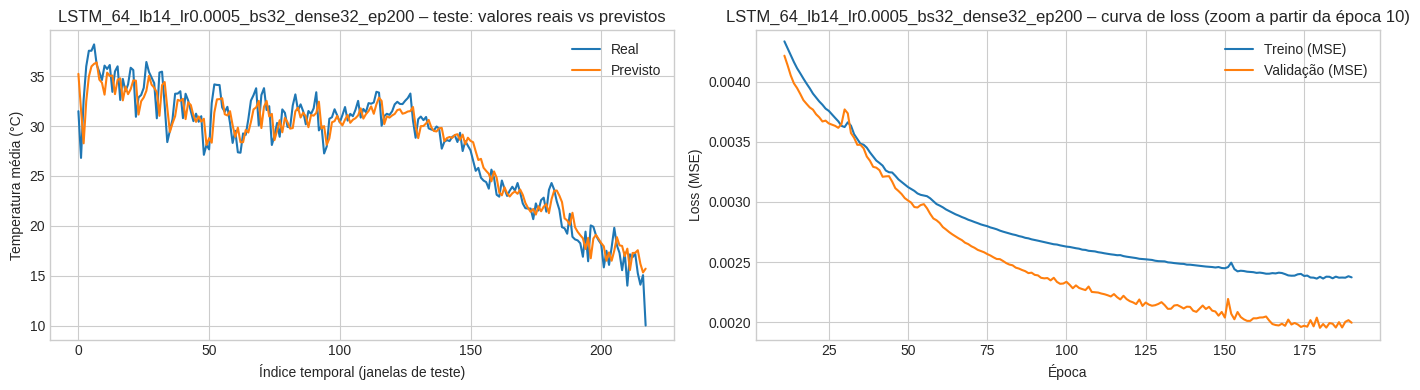


=== Modelo #3: LSTM_64_lb14_lr0.0005_bs32_dense16_ep200 (lookback=14) ===


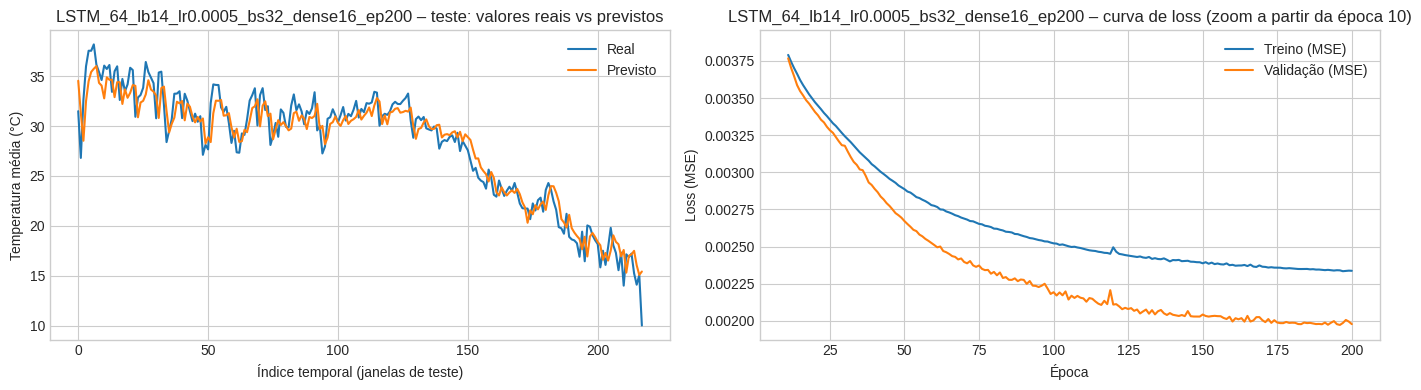


=== Modelo #4: LSTM_64_units_lookback14 (lookback=14) ===


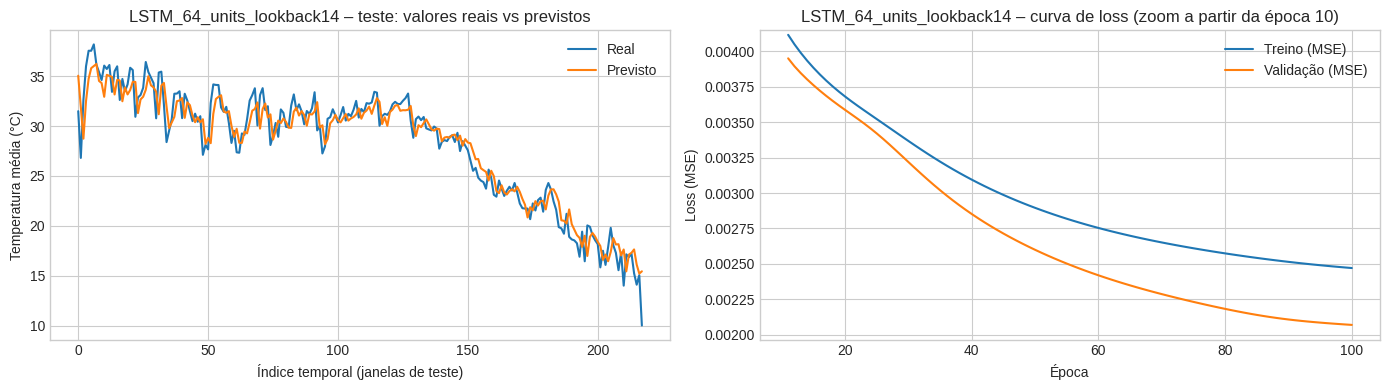


=== Modelo #5: LSTM_64_lb14_lr0.0002_ep200 (lookback=14) ===


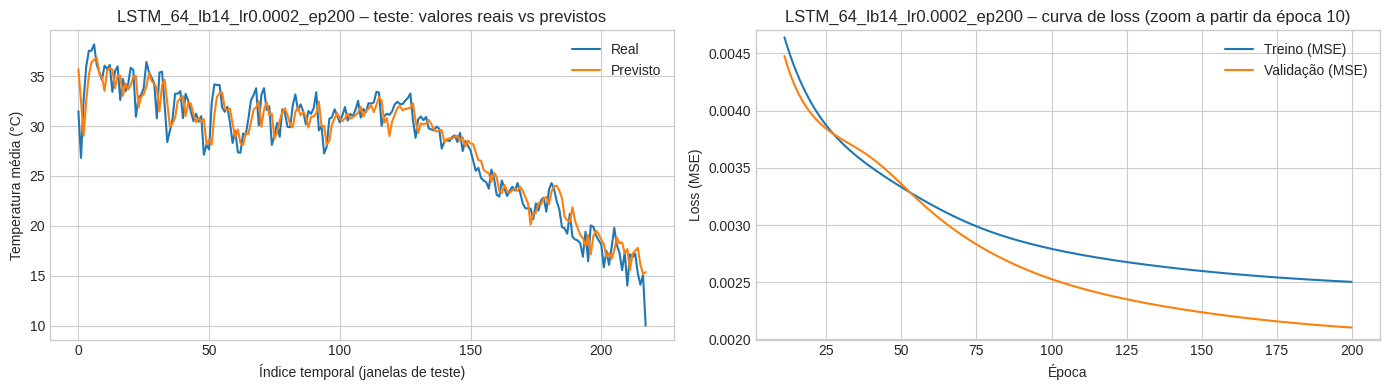

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Selecionar candidatos ordenados por val_rmse
candidatos = results_df.sort_values("val_rmse", ascending=True)

valid_rows = []
for _, row in candidatos.iterrows():
    name = row["model"]
    if name in trained_models and name in model_histories:
        valid_rows.append(row)
    if len(valid_rows) == 5:
        break

top5_valid = (
    (np.array(valid_rows).tolist())
)

# Reconstruir como DataFrame (caso você queira exibir bonitinho)
top5_df = resultados_top5 = (
    candidatos[candidatos["model"].isin([r["model"] for r in valid_rows])]
    .sort_values("val_rmse", ascending=True)
    .head(5)
    .reset_index(drop=True)
)

print("Top 5 modelos realmente disponíveis (ordenados por val_rmse):")
display(top5_df[["model", "lookback", "units_lstm", "batch_size",
                 "epochs_trained", "val_rmse", "test_rmse"]])

# 2) Função auxiliar para recriar os splits para um dado lookback
def get_splits_for_lookback(lookback: int):
    X_all, y_all = create_multivariate_sequences(X_scaled, y_scaled, lookback)
    n = X_all.shape[0]

    train_size = int(n * 0.7)
    val_size = int(n * 0.15)

    X_train = X_all[:train_size]
    y_train = y_all[:train_size]

    X_val = X_all[train_size:train_size + val_size]
    y_val = y_all[train_size:train_size + val_size]

    X_test = X_all[train_size + val_size:]
    y_test = y_all[train_size + val_size:]

    return X_train, y_train, X_val, y_val, X_test, y_test

zoom_start = 10  # época a partir da qual queremos o zoom nas curvas de loss

# 3) Loop pelos 5 melhores modelos e geração dos gráficos (com zoom no loss)
for rank, row in top5_df.iterrows():
    name = row["model"]
    lookback = int(row["lookback"])

    print(f"\n=== Modelo #{rank + 1}: {name} (lookback={lookback}) ===")

    if name not in trained_models or name not in model_histories:
        print(f"Aviso: modelo ou histórico não encontrado para {name}, pulando plots.")
        continue

    _, _, _, _, X_test, y_test = get_splits_for_lookback(lookback)
    model = trained_models[name]
    history = model_histories[name]

    # --- Previsões no conjunto de teste ---
    y_pred_scaled = model.predict(X_test, verbose=0)

    y_test_inv = scaler_y.inverse_transform(y_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred_scaled)

    y_true = y_test_inv.ravel()
    y_pred = y_pred_inv.ravel()

    # --- Curvas de loss ---
    losses = history.history["loss"]
    val_losses = history.history["val_loss"]
    epochs = np.arange(1, len(losses) + 1)

    # --- Figura com 2 gráficos: real vs previsto e loss com zoom ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # (a) Real vs previsto
    axes[0].plot(y_true, label="Real")
    axes[0].plot(y_pred, label="Previsto")
    axes[0].set_title(f"{name} – teste: valores reais vs previstos")
    axes[0].set_xlabel("Índice temporal (janelas de teste)")
    axes[0].set_ylabel("Temperatura média (°C)")
    axes[0].legend()
    axes[0].grid(True)

    # (b) Curva de loss com zoom
    axes[1].plot(epochs[zoom_start:], losses[zoom_start:], label="Treino (MSE)")
    axes[1].plot(epochs[zoom_start:], val_losses[zoom_start:], label="Validação (MSE)")
    axes[1].set_title(f"{name} – curva de loss (zoom a partir da época {zoom_start})")
    axes[1].set_xlabel("Época")
    axes[1].set_ylabel("Loss (MSE)")
    axes[1].legend()
    axes[1].grid(True)

    # Ajustar limites de y com base na validação nesse intervalo
    val_slice = val_losses[zoom_start:]
    ymin, ymax = min(val_slice), max(val_slice)
    axes[1].set_ylim(ymin * 0.95, ymax * 1.05)

    plt.tight_layout()
    plt.show()


## 5. Conclusões e trabalhos futuros

### 5.1 Síntese dos principais resultados

Este trabalho teve como objetivo estudar, implementar e analisar redes LSTM aplicadas à previsão de **temperatura média diária** em uma série temporal climática multivariada. Ao longo do notebook, seguimos uma abordagem incremental, começando de uma arquitetura simples e, passo a passo, explorando variações de arquitetura e de hiperparâmetros, sempre com base em **métricas quantitativas (RMSE/MAE)** e na **análise visual das curvas de loss** (treino vs validação) para avaliar overfitting.

Os principais resultados podem ser sintetizados da seguinte forma:

- **Qualidade geral do ajuste**
  - O melhor modelo foi capaz de **reproduzir bem a tendência e a sazonalidade** da série de temperatura média diária.
  - Os maiores erros aparecem em dias com **picos ou vales mais abruptos**, nos quais a LSTM tende a suavizar as variações – um comportamento típico de modelos de previsão baseados em erro quadrático.

- **Modelo final selecionado**
  - Arquitetura final:
    - 1 camada **LSTM com 64 unidades**
    - 1 camada de saída `Dense(1)`
  - Configuração de treinamento:
    - **lookback = 14 dias**
    - Otimizador **Adam** com `learning_rate = 0.0005`
    - **200 épocas** como limite, com *early stopping* (`patience = 10`)
    - `batch_size = 32`
    - **Sem dropout** e **sem camada densa intermediária**
  - Esse modelo apresentou o melhor equilíbrio entre:
    - **desempenho em validação** (menor `val_rmse` entre as combinações testadas);
    - **desempenho em teste**, na mesma ordem de grandeza do erro em validação;
    - **estabilidade das curvas de loss**, com treino e validação próximos e sem sinais fortes de overfitting.

- **Efeito dos principais hiperparâmetros**
  - **Número de unidades e profundidade da LSTM**
    - Aumentar de 32 para 64 unidades trouxe uma **melhora moderada** nas métricas.
    - Um modelo empilhado (LSTM 64–32) piorou significativamente o desempenho, indicando que, para este dataset, **a profundidade adicional não compensou**.
    - Aumentar para 128 unidades também não trouxe ganho e chegou a prejudicar as métricas.
  - **Tamanho da janela (lookback)**
    - `lookback = 14` dias superou as janelas de 30 e 60 dias em `val_rmse`, com curvas de loss mais estáveis.
    - Janelas muito longas (60 dias) aumentaram o ruído no treinamento e não melhoraram de forma consistente o desempenho em validação.
  - **Learning rate e épocas**
    - A combinação `lr = 0.0005` + até 200 épocas (com early stopping) permitiu ao Adam encontrar um mínimo melhor do que o `lr = 0.001`.
    - `lr` muito pequeno (0.0002) dificultou a convergência; `lr` maior (0.0015) convergiu mais rápido, porém para um mínimo pior.
  - **Batch size**
    - `batch_size = 32` se mostrou superior a 16 e 64, que pioraram o erro de validação e teste.
  - **Dropout e camadas densas intermediárias**
    - A inclusão de dropout na LSTM (0.2 e 0.4) prejudicou fortemente o aprendizado, aumentando o erro tanto em treino quanto em validação.
    - A adição de uma camada densa intermediária (Dense(16) ou Dense(32)) gerou métricas próximas, porém ligeiramente piores, além de curvas de validação mais ruidosas, com “spikes” compatíveis com **overfitting local**.

No conjunto, esses resultados mostram que, para esta série temporal, um **modelo relativamente simples** (LSTM de uma camada, 64 unidades, janela curta e configuração adequada de treinamento) já é suficiente para capturar a maior parte da estrutura temporal de forma estável.

---

### 5.2 Limitações do estudo

Apesar dos resultados satisfatórios, o trabalho apresenta algumas limitações importantes:

- **Escopo do problema**
  - Consideramos apenas a **previsão de um passo à frente** (temperatura média do próximo dia).
  - Não foram explorados cenários de **previsão multi-passo** (por exemplo, vários dias à frente) nem estratégias de previsão recursiva ou direta.

- **Estratégia de validação temporal**
  - Utilizamos uma divisão fixa em **treino/validação/teste** (70% / 15% / 15%).
  - Não foi implementada uma validação mais robusta do tipo **walk-forward** ou validação cruzada temporal, que poderia fornecer estimativas mais estáveis de desempenho em diferentes janelas no tempo.

- **Conjunto de dados e variáveis**
  - O estudo foi realizado sobre um **único dataset diário**, com um conjunto limitado de variáveis climáticas.
  - Não exploramos **features derivadas** (por exemplo, codificação de dia da semana, mês, sen/cos de dia do ano, indicadores de sazonalidade explícita, lags adicionais, médias móveis, etc.).

- **Espaço de modelos explorado**
  - O foco foi nas LSTMs. Outras arquiteturas também adequadas a sequências, como **GRU, CNN-LSTM, bidirectional LSTM, modelos com atenção ou Transformers para séries temporais**, não foram implementadas.
  - A busca de hiperparâmetros foi conduzida de forma **manual e guiada** (grid pequeno), sem uso de *hyperparameter tuning* automatizado (Random Search, Bayesian Optimization, etc.).

- **Interpretação do modelo**
  - Não foi feita uma análise sistemática de **importância de variáveis**, sensibilidade ou interpretabilidade (por exemplo, testes de “apagamento” de features, análise de contribuição temporal, etc.).
  - As conclusões são baseadas, principalmente, em métricas globais e na inspeção visual das previsões e resíduos.

Essas limitações não invalidam os resultados, mas indicam que eles devem ser interpretados como uma **primeira aproximação controlada** do problema, com espaço claro para refinamento.

---

### 5.3 Trabalhos futuros

A partir das conclusões e limitações, alguns caminhos naturais de extensão do trabalho são:

- **Novas variáveis e engenharia de features**
  - Incluir **variáveis de calendário** (dia da semana, mês, feriados, estações do ano), por meio de codificações numéricas ou cíclicas (por exemplo, seno e cosseno para o dia do ano).
  - Explorar **lags adicionais** e indicadores estatísticos (médias móveis, desvio-padrão local, máximas/mínimas em janelas recentes).
  - Avaliar o impacto de **features externas** (por exemplo, indicadores sazonais mais amplos, índices climáticos regionais).

- **Arquiteturas alternativas**
  - Testar **GRUs**, que são variações mais simples das LSTMs e, em muitos casos, entregam desempenho semelhante com menos parâmetros.
  - Avaliar arquiteturas **bidirecionais** (Bi-LSTM), desde que a aplicação permita usar informação “futura” no treinamento.
  - Explorar modelos híbridos, como **CNN-LSTM** (extração local de padrões + modelagem temporal) ou modelos com **mecanismos de atenção**.
  - Comparar o desempenho das LSTMs com abordagens mais recentes, como **Transformers adaptados para séries temporais**.

- **Estratégias de previsão e avaliação**
  - Extender o problema para **previsão multi-passo**, comparando estratégias recursivas (usar a própria previsão como entrada) e diretas (um modelo por horizonte).
  - Implementar **validação walk-forward** para avaliar o modelo em múltiplas janelas ao longo da série, aproximando mais o cenário de uso real.
  - Incluir **métricas adicionais**, como MAPE ou intervalos de confiança (previsão probabilística ou quantílica) para caracterizar a incerteza das previsões.

- **Regularização e robustez**
  - Reavaliar regularização (dropout, L2, early stopping mais agressivo) em cenários com modelos maiores ou com mais variáveis, onde o risco de overfitting seja mais pronunciado.
  - Investigar técnicas de **data augmentation temporal** (por exemplo, pequenas perturbações de ruído, janelas sobrepostas com diferentes anchors) para melhorar a robustez.

- **Interpretação e uso prático**
  - Aplicar métodos de interpretabilidade (por exemplo, análise de sensibilidade, *feature ablation*, SHAP em nível de sequência) para entender melhor como a LSTM utiliza cada variável ao longo do tempo.
  - Integrar o modelo em um **pipeline aplicado**, por exemplo, como componente de um sistema de monitoramento climático, avaliando:
    - desempenho em produção (drift de dados);
    - necessidade de **re-treino periódico**;
    - impacto real das previsões na tomada de decisão.

Em resumo, este estudo mostrou que **LSTMs simples, bem calibradas**, podem obter desempenho sólido na previsão de séries temporais climáticas, desde que haja cuidado na escolha de janelas, hiperparâmetros e no monitoramento de overfitting. Os próximos passos passam por ampliar o escopo (mais variáveis, mais horizontes de previsão, mais arquiteturas) e por aprofundar a **interpretação e a robustez** das soluções, aproximando o modelo de aplicações reais.
